In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = ""


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                            | 0/50000 [00:00<?, ?it/s]

  8%|█████▏                                                        | 4185/50000 [00:00<00:01, 41841.06it/s]

 17%|██████████▍                                                   | 8418/50000 [00:00<00:00, 42123.53it/s]

 26%|███████████████▊                                             | 12912/50000 [00:00<00:00, 43405.30it/s]

 35%|█████████████████████▏                                       | 17324/50000 [00:00<00:00, 43685.47it/s]

 43%|██████████████████████████▍                                  | 21693/50000 [00:00<00:00, 43675.89it/s]

 52%|███████████████████████████████▊                             | 26061/50000 [00:00<00:00, 43372.06it/s]

 61%|█████████████████████████████████████▏                       | 30519/50000 [00:00<00:00, 43763.35it/s]

 70%|██████████████████████████████████████████▋                  | 34987/50000 [00:00<00:00, 44054.00it/s]

 79%|████████████████████████████████████████████████             | 39421/50000 [00:00<00:00, 44140.69it/s]

 88%|█████████████████████████████████████████████████████▍       | 43836/50000 [00:01<00:00, 43038.63it/s]

 96%|██████████████████████████████████████████████████████████▋  | 48146/50000 [00:01<00:00, 42717.32it/s]

100%|█████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 43293.97it/s]

Files already downloaded and verified


  0%|                                                                            | 0/10000 [00:00<?, ?it/s]

 43%|██████████████████████████▊                                   | 4331/10000 [00:00<00:00, 43305.40it/s]

 87%|█████████████████████████████████████████████████████▋        | 8662/10000 [00:00<00:00, 41796.72it/s]

100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 42280.57it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 yk4jbpb0


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                              | 0/625 [00:00<?, ?it/s]

  0%|                                                                      | 1/625 [00:00<06:18,  1.65it/s]

  0%|▎                                                                     | 3/625 [00:00<02:12,  4.71it/s]

  1%|▌                                                                     | 5/625 [00:00<01:26,  7.13it/s]

  1%|▊                                                                     | 7/625 [00:01<01:08,  8.99it/s]

  1%|█                                                                     | 9/625 [00:01<00:59, 10.38it/s]

  2%|█▏                                                                   | 11/625 [00:01<00:53, 11.39it/s]

  2%|█▍                                                                   | 13/625 [00:01<00:50, 12.14it/s]

  2%|█▋                                                                   | 15/625 [00:01<00:48, 12.68it/s]

  3%|█▉                                                                   | 17/625 [00:01<00:46, 13.07it/s]

  3%|██                                                                   | 19/625 [00:01<00:45, 13.35it/s]

  3%|██▎                                                                  | 21/625 [00:02<00:44, 13.54it/s]

  4%|██▌                                                                  | 23/625 [00:02<00:44, 13.67it/s]

  4%|██▊                                                                  | 25/625 [00:02<00:43, 13.77it/s]

  4%|██▉                                                                  | 27/625 [00:02<00:43, 13.84it/s]

  5%|███▏                                                                 | 29/625 [00:02<00:42, 13.89it/s]

  5%|███▍                                                                 | 31/625 [00:02<00:42, 13.92it/s]

  5%|███▋                                                                 | 33/625 [00:02<00:42, 13.94it/s]

  6%|███▊                                                                 | 35/625 [00:03<00:42, 13.97it/s]

  6%|████                                                                 | 37/625 [00:03<00:42, 13.99it/s]

  6%|████▎                                                                | 39/625 [00:03<00:41, 13.99it/s]

  7%|████▌                                                                | 41/625 [00:03<00:41, 14.00it/s]

  7%|████▋                                                                | 43/625 [00:03<00:41, 14.01it/s]

  7%|████▉                                                                | 45/625 [00:03<00:41, 14.01it/s]

  8%|█████▏                                                               | 47/625 [00:03<00:41, 14.01it/s]

  8%|█████▍                                                               | 49/625 [00:04<00:41, 13.95it/s]

  8%|█████▋                                                               | 51/625 [00:04<00:41, 13.97it/s]

  8%|█████▊                                                               | 53/625 [00:04<00:40, 13.98it/s]

  9%|██████                                                               | 55/625 [00:04<00:40, 13.97it/s]

  9%|██████▎                                                              | 57/625 [00:04<00:40, 13.98it/s]

  9%|██████▌                                                              | 59/625 [00:04<00:40, 14.00it/s]

 10%|██████▋                                                              | 61/625 [00:04<00:40, 14.00it/s]

 10%|██████▉                                                              | 63/625 [00:05<00:40, 14.01it/s]

 10%|███████▏                                                             | 65/625 [00:05<00:39, 14.01it/s]

 11%|███████▍                                                             | 67/625 [00:05<00:39, 14.00it/s]

 11%|███████▌                                                             | 69/625 [00:05<00:39, 14.01it/s]

 11%|███████▊                                                             | 71/625 [00:05<00:39, 14.02it/s]

 12%|████████                                                             | 73/625 [00:05<00:39, 14.01it/s]

 12%|████████▎                                                            | 75/625 [00:05<00:39, 14.01it/s]

 12%|████████▌                                                            | 77/625 [00:06<00:39, 14.02it/s]

 13%|████████▋                                                            | 79/625 [00:06<00:38, 14.02it/s]

 13%|████████▉                                                            | 81/625 [00:06<00:38, 14.03it/s]

 13%|█████████▏                                                           | 83/625 [00:06<00:38, 14.02it/s]

 14%|█████████▍                                                           | 85/625 [00:06<00:38, 14.02it/s]

 14%|█████████▌                                                           | 87/625 [00:06<00:38, 14.02it/s]

 14%|█████████▊                                                           | 89/625 [00:06<00:38, 14.03it/s]

 15%|██████████                                                           | 91/625 [00:07<00:38, 14.03it/s]

 15%|██████████▎                                                          | 93/625 [00:07<00:37, 14.03it/s]

 15%|██████████▍                                                          | 95/625 [00:07<00:37, 14.03it/s]

 16%|██████████▋                                                          | 97/625 [00:07<00:37, 14.03it/s]

 16%|██████████▉                                                          | 99/625 [00:07<00:37, 14.03it/s]

 16%|██████████▉                                                         | 101/625 [00:07<00:37, 14.02it/s]

 16%|███████████▏                                                        | 103/625 [00:07<00:37, 14.02it/s]

 17%|███████████▍                                                        | 105/625 [00:08<00:37, 14.01it/s]

 17%|███████████▋                                                        | 107/625 [00:08<00:36, 14.01it/s]

 17%|███████████▊                                                        | 109/625 [00:08<00:36, 14.02it/s]

 18%|████████████                                                        | 111/625 [00:08<00:36, 14.03it/s]

 18%|████████████▎                                                       | 113/625 [00:08<00:36, 14.03it/s]

 18%|████████████▌                                                       | 115/625 [00:08<00:40, 12.56it/s]

 19%|████████████▋                                                       | 117/625 [00:08<00:42, 11.96it/s]

 19%|████████████▉                                                       | 119/625 [00:09<00:45, 11.02it/s]

 19%|█████████████▏                                                      | 121/625 [00:09<00:45, 11.19it/s]

 20%|█████████████▍                                                      | 123/625 [00:09<00:54,  9.26it/s]

 20%|█████████████▌                                                      | 125/625 [00:10<01:06,  7.48it/s]

 20%|█████████████▋                                                      | 126/625 [00:10<01:27,  5.72it/s]

 20%|█████████████▊                                                      | 127/625 [00:10<01:46,  4.68it/s]

 20%|█████████████▉                                                      | 128/625 [00:11<02:03,  4.04it/s]

 21%|██████████████                                                      | 129/625 [00:11<02:17,  3.62it/s]

 21%|██████████████▏                                                     | 130/625 [00:11<02:28,  3.34it/s]

 21%|██████████████▎                                                     | 131/625 [00:12<02:36,  3.15it/s]

 21%|██████████████▎                                                     | 132/625 [00:12<02:43,  3.02it/s]

 21%|██████████████▍                                                     | 133/625 [00:13<02:47,  2.93it/s]

 21%|██████████████▌                                                     | 134/625 [00:13<02:51,  2.87it/s]

 22%|██████████████▋                                                     | 135/625 [00:13<02:53,  2.83it/s]

 22%|██████████████▊                                                     | 136/625 [00:14<02:54,  2.80it/s]

 22%|██████████████▉                                                     | 137/625 [00:14<02:55,  2.78it/s]

 22%|███████████████                                                     | 138/625 [00:14<02:56,  2.76it/s]

 22%|███████████████                                                     | 139/625 [00:15<02:56,  2.75it/s]

 22%|███████████████▏                                                    | 140/625 [00:15<02:56,  2.74it/s]

 23%|███████████████▎                                                    | 141/625 [00:15<02:56,  2.74it/s]

 23%|███████████████▍                                                    | 142/625 [00:16<02:56,  2.73it/s]

 23%|███████████████▌                                                    | 143/625 [00:16<02:56,  2.73it/s]

 23%|███████████████▋                                                    | 144/625 [00:17<02:56,  2.73it/s]

 23%|███████████████▊                                                    | 145/625 [00:17<02:55,  2.73it/s]

 23%|███████████████▉                                                    | 146/625 [00:17<02:55,  2.73it/s]

 24%|███████████████▉                                                    | 147/625 [00:18<02:55,  2.73it/s]

 24%|████████████████                                                    | 148/625 [00:18<02:54,  2.73it/s]

 24%|████████████████▏                                                   | 149/625 [00:18<02:54,  2.73it/s]

 24%|████████████████▎                                                   | 150/625 [00:19<02:54,  2.73it/s]

 24%|████████████████▍                                                   | 151/625 [00:19<02:53,  2.73it/s]

 24%|████████████████▌                                                   | 152/625 [00:19<02:53,  2.73it/s]

 24%|████████████████▋                                                   | 153/625 [00:20<02:53,  2.73it/s]

 25%|████████████████▊                                                   | 154/625 [00:20<02:52,  2.73it/s]

 25%|████████████████▊                                                   | 155/625 [00:21<02:52,  2.73it/s]

 25%|████████████████▉                                                   | 156/625 [00:21<02:52,  2.73it/s]

 25%|█████████████████                                                   | 157/625 [00:21<02:51,  2.73it/s]

 25%|█████████████████▏                                                  | 158/625 [00:22<02:51,  2.73it/s]

 25%|█████████████████▎                                                  | 159/625 [00:22<02:50,  2.73it/s]

 26%|█████████████████▍                                                  | 160/625 [00:22<02:50,  2.73it/s]

 26%|█████████████████▌                                                  | 161/625 [00:23<02:50,  2.73it/s]

 26%|█████████████████▋                                                  | 162/625 [00:23<02:49,  2.73it/s]

 26%|█████████████████▋                                                  | 163/625 [00:24<02:49,  2.73it/s]

 26%|█████████████████▊                                                  | 164/625 [00:24<02:49,  2.73it/s]

 26%|█████████████████▉                                                  | 165/625 [00:24<02:48,  2.73it/s]

 27%|██████████████████                                                  | 166/625 [00:25<02:48,  2.73it/s]

 27%|██████████████████▏                                                 | 167/625 [00:25<02:47,  2.73it/s]

 27%|██████████████████▎                                                 | 168/625 [00:25<02:47,  2.73it/s]

 27%|██████████████████▍                                                 | 169/625 [00:26<02:47,  2.73it/s]

 27%|██████████████████▍                                                 | 170/625 [00:26<02:46,  2.73it/s]

 27%|██████████████████▌                                                 | 171/625 [00:26<02:46,  2.73it/s]

 28%|██████████████████▋                                                 | 172/625 [00:27<02:45,  2.73it/s]

 28%|██████████████████▊                                                 | 173/625 [00:27<02:45,  2.73it/s]

 28%|██████████████████▉                                                 | 174/625 [00:28<02:45,  2.73it/s]

 28%|███████████████████                                                 | 175/625 [00:28<02:44,  2.73it/s]

 28%|███████████████████▏                                                | 176/625 [00:28<02:44,  2.73it/s]

 28%|███████████████████▎                                                | 177/625 [00:29<02:44,  2.73it/s]

 28%|███████████████████▎                                                | 178/625 [00:29<02:43,  2.73it/s]

 29%|███████████████████▍                                                | 179/625 [00:29<02:43,  2.73it/s]

 29%|███████████████████▌                                                | 180/625 [00:30<02:43,  2.73it/s]

 29%|███████████████████▋                                                | 181/625 [00:30<02:42,  2.74it/s]

 29%|███████████████████▊                                                | 182/625 [00:30<02:42,  2.73it/s]

 29%|███████████████████▉                                                | 183/625 [00:31<02:42,  2.73it/s]

 29%|████████████████████                                                | 184/625 [00:31<02:41,  2.73it/s]

 30%|████████████████████▏                                               | 185/625 [00:32<02:41,  2.73it/s]

 30%|████████████████████▏                                               | 186/625 [00:32<02:40,  2.73it/s]

 30%|████████████████████▎                                               | 187/625 [00:32<02:40,  2.73it/s]

 30%|████████████████████▍                                               | 188/625 [00:33<02:40,  2.73it/s]

 30%|████████████████████▌                                               | 189/625 [00:33<02:39,  2.73it/s]

 30%|████████████████████▋                                               | 190/625 [00:33<02:39,  2.73it/s]

 31%|████████████████████▊                                               | 191/625 [00:34<02:39,  2.73it/s]

 31%|████████████████████▉                                               | 192/625 [00:34<02:38,  2.73it/s]

 31%|████████████████████▉                                               | 193/625 [00:35<02:38,  2.73it/s]

 31%|█████████████████████                                               | 194/625 [00:35<02:37,  2.73it/s]

 31%|█████████████████████▏                                              | 195/625 [00:35<02:37,  2.73it/s]

 31%|█████████████████████▎                                              | 196/625 [00:36<02:37,  2.73it/s]

 32%|█████████████████████▍                                              | 197/625 [00:36<02:36,  2.73it/s]

 32%|█████████████████████▌                                              | 198/625 [00:36<02:36,  2.73it/s]

 32%|█████████████████████▋                                              | 199/625 [00:37<02:36,  2.73it/s]

 32%|█████████████████████▊                                              | 200/625 [00:37<02:35,  2.73it/s]

 32%|█████████████████████▊                                              | 201/625 [00:37<02:35,  2.73it/s]

 32%|█████████████████████▉                                              | 202/625 [00:38<02:35,  2.73it/s]

 32%|██████████████████████                                              | 203/625 [00:38<02:34,  2.73it/s]

 33%|██████████████████████▏                                             | 204/625 [00:39<02:34,  2.73it/s]

 33%|██████████████████████▎                                             | 205/625 [00:39<02:33,  2.73it/s]

 33%|██████████████████████▍                                             | 206/625 [00:39<02:33,  2.73it/s]

 33%|██████████████████████▌                                             | 207/625 [00:40<02:33,  2.73it/s]

 33%|██████████████████████▋                                             | 208/625 [00:40<02:32,  2.73it/s]

 33%|██████████████████████▋                                             | 209/625 [00:40<02:32,  2.73it/s]

 34%|██████████████████████▊                                             | 210/625 [00:41<02:32,  2.73it/s]

 34%|██████████████████████▉                                             | 211/625 [00:41<02:31,  2.73it/s]

 34%|███████████████████████                                             | 212/625 [00:41<02:31,  2.73it/s]

 34%|███████████████████████▏                                            | 213/625 [00:42<02:31,  2.73it/s]

 34%|███████████████████████▎                                            | 214/625 [00:42<02:30,  2.73it/s]

 34%|███████████████████████▍                                            | 215/625 [00:43<02:30,  2.73it/s]

 35%|███████████████████████▌                                            | 216/625 [00:43<02:29,  2.73it/s]

 35%|███████████████████████▌                                            | 217/625 [00:43<02:29,  2.73it/s]

 35%|███████████████████████▋                                            | 218/625 [00:44<02:29,  2.73it/s]

 35%|███████████████████████▊                                            | 219/625 [00:44<02:28,  2.73it/s]

 35%|███████████████████████▉                                            | 220/625 [00:44<02:28,  2.73it/s]

 35%|████████████████████████                                            | 221/625 [00:45<02:28,  2.73it/s]

 36%|████████████████████████▏                                           | 222/625 [00:45<02:27,  2.73it/s]

 36%|████████████████████████▎                                           | 223/625 [00:46<02:27,  2.73it/s]

 36%|████████████████████████▎                                           | 224/625 [00:46<02:27,  2.73it/s]

 36%|████████████████████████▍                                           | 225/625 [00:46<02:26,  2.73it/s]

 36%|████████████████████████▌                                           | 226/625 [00:47<02:26,  2.73it/s]

 36%|████████████████████████▋                                           | 227/625 [00:47<02:25,  2.73it/s]

 36%|████████████████████████▊                                           | 228/625 [00:47<02:25,  2.73it/s]

 37%|████████████████████████▉                                           | 229/625 [00:48<02:25,  2.73it/s]

 37%|█████████████████████████                                           | 230/625 [00:48<02:24,  2.73it/s]

 37%|█████████████████████████▏                                          | 231/625 [00:48<02:24,  2.73it/s]

 37%|█████████████████████████▏                                          | 232/625 [00:49<02:24,  2.73it/s]

 37%|█████████████████████████▎                                          | 233/625 [00:49<02:23,  2.73it/s]

 37%|█████████████████████████▍                                          | 234/625 [00:50<02:23,  2.73it/s]

 38%|█████████████████████████▌                                          | 235/625 [00:50<02:22,  2.73it/s]

 38%|█████████████████████████▋                                          | 236/625 [00:50<02:22,  2.73it/s]

 38%|█████████████████████████▊                                          | 237/625 [00:51<02:22,  2.73it/s]

 38%|█████████████████████████▉                                          | 238/625 [00:51<02:21,  2.73it/s]

 38%|██████████████████████████                                          | 239/625 [00:51<02:21,  2.73it/s]

 38%|██████████████████████████                                          | 240/625 [00:52<02:20,  2.74it/s]

 39%|██████████████████████████▏                                         | 241/625 [00:52<02:20,  2.73it/s]

 39%|██████████████████████████▎                                         | 242/625 [00:52<02:20,  2.73it/s]

 39%|██████████████████████████▍                                         | 243/625 [00:53<02:20,  2.73it/s]

 39%|██████████████████████████▌                                         | 244/625 [00:53<02:19,  2.73it/s]

 39%|██████████████████████████▋                                         | 245/625 [00:54<02:19,  2.73it/s]

 39%|██████████████████████████▊                                         | 246/625 [00:54<02:18,  2.73it/s]

 40%|██████████████████████████▊                                         | 247/625 [00:54<02:18,  2.73it/s]

 40%|██████████████████████████▉                                         | 248/625 [00:55<02:18,  2.73it/s]

 40%|███████████████████████████                                         | 249/625 [00:55<02:17,  2.73it/s]

 40%|███████████████████████████▏                                        | 250/625 [00:55<02:17,  2.73it/s]

 40%|███████████████████████████▎                                        | 251/625 [00:56<02:17,  2.73it/s]

 40%|███████████████████████████▍                                        | 252/625 [00:56<02:17,  2.72it/s]

 40%|███████████████████████████▌                                        | 253/625 [00:56<02:16,  2.73it/s]

 41%|███████████████████████████▋                                        | 254/625 [00:57<02:15,  2.73it/s]

 41%|███████████████████████████▋                                        | 255/625 [00:57<02:15,  2.73it/s]

 41%|███████████████████████████▊                                        | 256/625 [00:58<02:10,  2.83it/s]

 41%|███████████████████████████▉                                        | 257/625 [00:58<01:43,  3.57it/s]

 41%|████████████████████████████▏                                       | 259/625 [00:58<01:23,  4.36it/s]

 42%|████████████████████████████▎                                       | 260/625 [00:58<01:36,  3.80it/s]

 42%|████████████████████████████▍                                       | 261/625 [00:59<01:45,  3.46it/s]

 42%|████████████████████████████▌                                       | 262/625 [00:59<01:53,  3.21it/s]

 42%|████████████████████████████▌                                       | 263/625 [00:59<01:57,  3.07it/s]

 42%|████████████████████████████▋                                       | 264/625 [01:00<02:02,  2.95it/s]

 42%|████████████████████████████▊                                       | 265/625 [01:00<02:04,  2.90it/s]

 43%|████████████████████████████▉                                       | 266/625 [01:01<02:06,  2.83it/s]

 43%|█████████████████████████████                                       | 267/625 [01:01<02:07,  2.80it/s]

 43%|█████████████████████████████▏                                      | 268/625 [01:01<02:08,  2.78it/s]

 43%|█████████████████████████████▎                                      | 269/625 [01:02<02:08,  2.78it/s]

 43%|█████████████████████████████▍                                      | 270/625 [01:02<02:09,  2.75it/s]

 43%|█████████████████████████████▍                                      | 271/625 [01:02<02:09,  2.74it/s]

 44%|█████████████████████████████▌                                      | 272/625 [01:03<02:08,  2.74it/s]

 44%|█████████████████████████████▋                                      | 273/625 [01:03<02:08,  2.74it/s]

 44%|█████████████████████████████▊                                      | 274/625 [01:04<02:08,  2.73it/s]

 44%|█████████████████████████████▉                                      | 275/625 [01:04<02:00,  2.90it/s]

 44%|██████████████████████████████▏                                     | 277/625 [01:04<01:17,  4.48it/s]

 45%|██████████████████████████████▎                                     | 279/625 [01:04<01:17,  4.46it/s]

 45%|██████████████████████████████▍                                     | 280/625 [01:05<01:28,  3.89it/s]

 45%|██████████████████████████████▌                                     | 281/625 [01:05<01:37,  3.55it/s]

 45%|██████████████████████████████▋                                     | 282/625 [01:06<01:44,  3.28it/s]

 45%|██████████████████████████████▊                                     | 283/625 [01:06<01:49,  3.12it/s]

 45%|██████████████████████████████▉                                     | 284/625 [01:06<01:53,  3.00it/s]

 46%|███████████████████████████████                                     | 285/625 [01:07<01:56,  2.92it/s]

 46%|███████████████████████████████                                     | 286/625 [01:07<01:58,  2.85it/s]

 46%|███████████████████████████████▏                                    | 287/625 [01:07<01:59,  2.83it/s]

 46%|███████████████████████████████▎                                    | 288/625 [01:08<02:00,  2.79it/s]

 46%|███████████████████████████████▍                                    | 289/625 [01:08<02:00,  2.78it/s]

 46%|███████████████████████████████▌                                    | 290/625 [01:08<02:01,  2.76it/s]

 47%|███████████████████████████████▋                                    | 291/625 [01:09<02:01,  2.76it/s]

 47%|███████████████████████████████▊                                    | 292/625 [01:09<02:01,  2.74it/s]

 47%|███████████████████████████████▉                                    | 293/625 [01:10<02:00,  2.75it/s]

 47%|███████████████████████████████▉                                    | 294/625 [01:10<02:01,  2.73it/s]

 47%|████████████████████████████████                                    | 295/625 [01:10<01:44,  3.17it/s]

 48%|████████████████████████████████▎                                   | 297/625 [01:10<01:06,  4.92it/s]

 48%|████████████████████████████████▍                                   | 298/625 [01:10<01:02,  5.26it/s]

 48%|████████████████████████████████▌                                   | 299/625 [01:11<01:17,  4.23it/s]

 48%|████████████████████████████████▋                                   | 300/625 [01:11<01:27,  3.70it/s]

 48%|████████████████████████████████▋                                   | 301/625 [01:12<01:36,  3.35it/s]

 48%|████████████████████████████████▊                                   | 302/625 [01:12<01:42,  3.16it/s]

 48%|████████████████████████████████▉                                   | 303/625 [01:12<01:47,  3.01it/s]

 49%|█████████████████████████████████                                   | 304/625 [01:13<01:49,  2.93it/s]

 49%|█████████████████████████████████▏                                  | 305/625 [01:13<01:52,  2.86it/s]

 49%|█████████████████████████████████▎                                  | 306/625 [01:13<01:52,  2.83it/s]

 49%|█████████████████████████████████▍                                  | 307/625 [01:14<01:54,  2.79it/s]

 49%|█████████████████████████████████▌                                  | 308/625 [01:14<01:54,  2.78it/s]

 49%|█████████████████████████████████▌                                  | 309/625 [01:14<01:54,  2.75it/s]

 50%|█████████████████████████████████▋                                  | 310/625 [01:15<01:54,  2.76it/s]

 50%|█████████████████████████████████▊                                  | 311/625 [01:15<01:54,  2.74it/s]

 50%|█████████████████████████████████▉                                  | 312/625 [01:16<01:54,  2.73it/s]

 50%|██████████████████████████████████                                  | 313/625 [01:16<01:54,  2.73it/s]

 50%|██████████████████████████████████▏                                 | 314/625 [01:16<01:53,  2.73it/s]

 50%|██████████████████████████████████▎                                 | 315/625 [01:17<01:53,  2.73it/s]

 51%|██████████████████████████████████▍                                 | 316/625 [01:17<01:52,  2.74it/s]

 51%|██████████████████████████████████▍                                 | 317/625 [01:17<01:53,  2.72it/s]

 51%|██████████████████████████████████▌                                 | 318/625 [01:18<01:52,  2.74it/s]

 51%|██████████████████████████████████▋                                 | 319/625 [01:18<01:52,  2.72it/s]

 51%|██████████████████████████████████▊                                 | 320/625 [01:18<01:51,  2.73it/s]

 51%|██████████████████████████████████▉                                 | 321/625 [01:19<01:51,  2.72it/s]

 52%|███████████████████████████████████                                 | 322/625 [01:19<01:50,  2.74it/s]

 52%|███████████████████████████████████▏                                | 323/625 [01:20<01:50,  2.72it/s]

 52%|███████████████████████████████████▎                                | 324/625 [01:20<01:50,  2.72it/s]

 52%|███████████████████████████████████▎                                | 325/625 [01:20<01:50,  2.73it/s]

 52%|███████████████████████████████████▍                                | 326/625 [01:21<01:49,  2.73it/s]

 52%|███████████████████████████████████▌                                | 327/625 [01:21<01:49,  2.73it/s]

 52%|███████████████████████████████████▋                                | 328/625 [01:21<01:48,  2.74it/s]

 53%|███████████████████████████████████▊                                | 329/625 [01:22<01:48,  2.72it/s]

 53%|███████████████████████████████████▉                                | 330/625 [01:22<01:47,  2.74it/s]

 53%|████████████████████████████████████                                | 331/625 [01:23<01:48,  2.72it/s]

 53%|████████████████████████████████████                                | 332/625 [01:23<01:47,  2.73it/s]

 53%|████████████████████████████████████▏                               | 333/625 [01:23<01:47,  2.72it/s]

 53%|████████████████████████████████████▎                               | 334/625 [01:24<01:46,  2.74it/s]

 54%|████████████████████████████████████▍                               | 335/625 [01:24<01:46,  2.72it/s]

 54%|████████████████████████████████████▌                               | 336/625 [01:24<01:45,  2.73it/s]

 54%|████████████████████████████████████▋                               | 337/625 [01:25<01:45,  2.72it/s]

 54%|████████████████████████████████████▊                               | 338/625 [01:25<01:44,  2.74it/s]

 54%|████████████████████████████████████▉                               | 339/625 [01:25<01:45,  2.72it/s]

 54%|████████████████████████████████████▉                               | 340/625 [01:26<01:44,  2.74it/s]

 55%|█████████████████████████████████████                               | 341/625 [01:26<01:44,  2.72it/s]

 55%|█████████████████████████████████████▏                              | 342/625 [01:27<01:43,  2.73it/s]

 55%|█████████████████████████████████████▎                              | 343/625 [01:27<01:43,  2.72it/s]

 55%|█████████████████████████████████████▍                              | 344/625 [01:27<01:42,  2.73it/s]

 55%|█████████████████████████████████████▌                              | 345/625 [01:28<01:42,  2.72it/s]

 55%|█████████████████████████████████████▋                              | 346/625 [01:28<01:42,  2.72it/s]

 56%|█████████████████████████████████████▊                              | 347/625 [01:28<01:42,  2.72it/s]

 56%|█████████████████████████████████████▊                              | 348/625 [01:29<01:41,  2.74it/s]

 56%|█████████████████████████████████████▉                              | 349/625 [01:29<01:41,  2.72it/s]

 56%|██████████████████████████████████████                              | 350/625 [01:29<01:40,  2.74it/s]

 56%|██████████████████████████████████████▏                             | 351/625 [01:30<01:40,  2.72it/s]

 56%|██████████████████████████████████████▎                             | 352/625 [01:30<01:39,  2.74it/s]

 56%|██████████████████████████████████████▍                             | 353/625 [01:31<01:39,  2.72it/s]

 57%|██████████████████████████████████████▌                             | 354/625 [01:31<01:39,  2.73it/s]

 57%|██████████████████████████████████████▌                             | 355/625 [01:31<01:39,  2.72it/s]

 57%|██████████████████████████████████████▋                             | 356/625 [01:32<01:38,  2.74it/s]

 57%|██████████████████████████████████████▊                             | 357/625 [01:32<01:38,  2.72it/s]

 57%|██████████████████████████████████████▉                             | 358/625 [01:32<01:37,  2.73it/s]

 57%|███████████████████████████████████████                             | 359/625 [01:33<01:37,  2.72it/s]

 58%|███████████████████████████████████████▏                            | 360/625 [01:33<01:36,  2.74it/s]

 58%|███████████████████████████████████████▎                            | 361/625 [01:34<01:36,  2.72it/s]

 58%|███████████████████████████████████████▍                            | 362/625 [01:34<01:36,  2.74it/s]

 58%|███████████████████████████████████████▍                            | 363/625 [01:34<01:36,  2.72it/s]

 58%|███████████████████████████████████████▌                            | 364/625 [01:35<01:35,  2.74it/s]

 58%|███████████████████████████████████████▋                            | 365/625 [01:35<01:35,  2.72it/s]

 59%|███████████████████████████████████████▊                            | 366/625 [01:35<01:34,  2.74it/s]

 59%|███████████████████████████████████████▉                            | 367/625 [01:36<01:34,  2.72it/s]

 59%|████████████████████████████████████████                            | 368/625 [01:36<01:33,  2.74it/s]

 59%|████████████████████████████████████████▏                           | 369/625 [01:36<01:33,  2.72it/s]

 59%|████████████████████████████████████████▎                           | 370/625 [01:37<01:33,  2.74it/s]

 59%|████████████████████████████████████████▎                           | 371/625 [01:37<01:33,  2.72it/s]

 60%|████████████████████████████████████████▍                           | 372/625 [01:38<01:32,  2.74it/s]

 60%|████████████████████████████████████████▌                           | 373/625 [01:38<01:32,  2.72it/s]

 60%|████████████████████████████████████████▋                           | 374/625 [01:38<01:31,  2.74it/s]

 60%|████████████████████████████████████████▊                           | 375/625 [01:39<01:31,  2.72it/s]

 60%|████████████████████████████████████████▉                           | 376/625 [01:39<01:31,  2.74it/s]

 60%|█████████████████████████████████████████                           | 377/625 [01:39<01:31,  2.72it/s]

 60%|█████████████████████████████████████████▏                          | 378/625 [01:40<01:30,  2.74it/s]

 61%|█████████████████████████████████████████▏                          | 379/625 [01:40<01:30,  2.73it/s]

 61%|█████████████████████████████████████████▎                          | 380/625 [01:40<01:29,  2.73it/s]

 61%|█████████████████████████████████████████▍                          | 381/625 [01:41<01:29,  2.72it/s]

 61%|█████████████████████████████████████████▌                          | 382/625 [01:41<01:28,  2.73it/s]

 61%|█████████████████████████████████████████▋                          | 383/625 [01:42<01:28,  2.72it/s]

 61%|█████████████████████████████████████████▊                          | 384/625 [01:42<01:28,  2.73it/s]

 62%|█████████████████████████████████████████▉                          | 385/625 [01:42<01:28,  2.72it/s]

 62%|█████████████████████████████████████████▉                          | 386/625 [01:43<01:27,  2.74it/s]

 62%|██████████████████████████████████████████                          | 387/625 [01:43<01:27,  2.72it/s]

 62%|██████████████████████████████████████████▏                         | 388/625 [01:43<01:26,  2.73it/s]

 62%|██████████████████████████████████████████▎                         | 389/625 [01:44<01:26,  2.72it/s]

 62%|██████████████████████████████████████████▍                         | 390/625 [01:44<01:25,  2.73it/s]

 63%|██████████████████████████████████████████▌                         | 391/625 [01:44<01:25,  2.72it/s]

 63%|██████████████████████████████████████████▋                         | 392/625 [01:45<01:25,  2.74it/s]

 63%|██████████████████████████████████████████▊                         | 393/625 [01:45<01:25,  2.72it/s]

 63%|██████████████████████████████████████████▊                         | 394/625 [01:46<01:24,  2.73it/s]

 63%|██████████████████████████████████████████▉                         | 395/625 [01:46<01:24,  2.72it/s]

 63%|███████████████████████████████████████████                         | 396/625 [01:46<01:23,  2.73it/s]

 64%|███████████████████████████████████████████▏                        | 397/625 [01:47<01:23,  2.72it/s]

 64%|███████████████████████████████████████████▎                        | 398/625 [01:47<01:22,  2.73it/s]

 64%|███████████████████████████████████████████▍                        | 399/625 [01:47<01:23,  2.72it/s]

 64%|███████████████████████████████████████████▌                        | 400/625 [01:48<01:22,  2.73it/s]

 64%|███████████████████████████████████████████▋                        | 401/625 [01:48<01:22,  2.72it/s]

 64%|███████████████████████████████████████████▋                        | 402/625 [01:49<01:21,  2.74it/s]

 64%|███████████████████████████████████████████▊                        | 403/625 [01:49<01:21,  2.72it/s]

 65%|███████████████████████████████████████████▉                        | 404/625 [01:49<01:20,  2.74it/s]

 65%|████████████████████████████████████████████                        | 405/625 [01:50<01:20,  2.72it/s]

 65%|████████████████████████████████████████████▏                       | 406/625 [01:50<01:20,  2.74it/s]

 65%|████████████████████████████████████████████▎                       | 407/625 [01:50<01:20,  2.72it/s]

 65%|████████████████████████████████████████████▍                       | 408/625 [01:51<01:19,  2.74it/s]

 65%|████████████████████████████████████████████▍                       | 409/625 [01:51<01:19,  2.72it/s]

 66%|████████████████████████████████████████████▌                       | 410/625 [01:51<01:18,  2.74it/s]

 66%|████████████████████████████████████████████▋                       | 411/625 [01:52<01:18,  2.72it/s]

 66%|████████████████████████████████████████████▊                       | 412/625 [01:52<01:17,  2.74it/s]

 66%|████████████████████████████████████████████▉                       | 413/625 [01:53<01:17,  2.72it/s]

 66%|█████████████████████████████████████████████                       | 414/625 [01:53<01:17,  2.72it/s]

 66%|█████████████████████████████████████████████▏                      | 415/625 [01:53<01:17,  2.73it/s]

 67%|█████████████████████████████████████████████▎                      | 416/625 [01:54<01:16,  2.73it/s]

 67%|█████████████████████████████████████████████▎                      | 417/625 [01:54<01:16,  2.73it/s]

 67%|█████████████████████████████████████████████▍                      | 418/625 [01:54<01:15,  2.74it/s]

 67%|█████████████████████████████████████████████▌                      | 419/625 [01:55<01:15,  2.72it/s]

 67%|█████████████████████████████████████████████▋                      | 420/625 [01:55<01:14,  2.73it/s]

 67%|█████████████████████████████████████████████▊                      | 421/625 [01:55<01:14,  2.72it/s]

 68%|█████████████████████████████████████████████▉                      | 422/625 [01:56<01:14,  2.73it/s]

 68%|██████████████████████████████████████████████                      | 423/625 [01:56<01:14,  2.72it/s]

 68%|██████████████████████████████████████████████▏                     | 424/625 [01:57<01:13,  2.73it/s]

 68%|██████████████████████████████████████████████▏                     | 425/625 [01:57<01:13,  2.72it/s]

 68%|██████████████████████████████████████████████▎                     | 426/625 [01:57<01:12,  2.74it/s]

 68%|██████████████████████████████████████████████▍                     | 427/625 [01:58<01:12,  2.72it/s]

 68%|██████████████████████████████████████████████▌                     | 428/625 [01:58<01:12,  2.73it/s]

 69%|██████████████████████████████████████████████▋                     | 429/625 [01:58<01:12,  2.72it/s]

 69%|██████████████████████████████████████████████▊                     | 430/625 [01:59<01:11,  2.73it/s]

 69%|██████████████████████████████████████████████▉                     | 431/625 [01:59<01:11,  2.72it/s]

 69%|███████████████████████████████████████████████                     | 432/625 [02:00<01:10,  2.73it/s]

 69%|███████████████████████████████████████████████                     | 433/625 [02:00<01:10,  2.72it/s]

 69%|███████████████████████████████████████████████▏                    | 434/625 [02:00<01:05,  2.91it/s]

 70%|███████████████████████████████████████████████▍                    | 436/625 [02:00<00:41,  4.58it/s]

 70%|███████████████████████████████████████████████▌                    | 437/625 [02:01<00:41,  4.48it/s]

 70%|███████████████████████████████████████████████▋                    | 438/625 [02:01<00:49,  3.77it/s]

 70%|███████████████████████████████████████████████▊                    | 439/625 [02:01<00:55,  3.38it/s]

 70%|███████████████████████████████████████████████▊                    | 440/625 [02:02<00:58,  3.15it/s]

 71%|███████████████████████████████████████████████▉                    | 441/625 [02:02<01:02,  2.96it/s]

 71%|████████████████████████████████████████████████                    | 442/625 [02:02<01:03,  2.87it/s]

 71%|████████████████████████████████████████████████▏                   | 443/625 [02:03<01:05,  2.80it/s]

 71%|████████████████████████████████████████████████▎                   | 444/625 [02:03<01:05,  2.75it/s]

 71%|████████████████████████████████████████████████▍                   | 445/625 [02:04<01:05,  2.73it/s]

 71%|████████████████████████████████████████████████▌                   | 446/625 [02:04<01:06,  2.68it/s]

 72%|████████████████████████████████████████████████▋                   | 447/625 [02:04<01:06,  2.68it/s]

 72%|████████████████████████████████████████████████▋                   | 448/625 [02:05<01:06,  2.67it/s]

 72%|████████████████████████████████████████████████▊                   | 449/625 [02:05<01:06,  2.66it/s]

 72%|████████████████████████████████████████████████▉                   | 450/625 [02:06<01:06,  2.62it/s]

 72%|█████████████████████████████████████████████████                   | 451/625 [02:06<01:06,  2.61it/s]

 72%|█████████████████████████████████████████████████▏                  | 452/625 [02:06<01:06,  2.62it/s]

 72%|█████████████████████████████████████████████████▎                  | 453/625 [02:07<01:06,  2.59it/s]

 73%|█████████████████████████████████████████████████▍                  | 454/625 [02:07<01:05,  2.59it/s]

 73%|█████████████████████████████████████████████████▌                  | 455/625 [02:07<01:05,  2.61it/s]

 73%|█████████████████████████████████████████████████▌                  | 456/625 [02:08<00:57,  2.96it/s]

 73%|█████████████████████████████████████████████████▊                  | 458/625 [02:08<00:35,  4.65it/s]

 74%|██████████████████████████████████████████████████                  | 460/625 [02:08<00:26,  6.33it/s]

 74%|██████████████████████████████████████████████████▎                 | 462/625 [02:08<00:20,  7.90it/s]

 74%|██████████████████████████████████████████████████▍                 | 464/625 [02:08<00:17,  9.27it/s]

 75%|██████████████████████████████████████████████████▋                 | 466/625 [02:08<00:15, 10.42it/s]

 75%|██████████████████████████████████████████████████▉                 | 468/625 [02:09<00:13, 11.35it/s]

 75%|███████████████████████████████████████████████████▏                | 470/625 [02:09<00:12, 12.08it/s]

 76%|███████████████████████████████████████████████████▎                | 472/625 [02:09<00:12, 12.62it/s]

 76%|███████████████████████████████████████████████████▌                | 474/625 [02:09<00:11, 13.03it/s]

 76%|███████████████████████████████████████████████████▊                | 476/625 [02:09<00:11, 13.34it/s]

 76%|████████████████████████████████████████████████████                | 478/625 [02:09<00:10, 13.54it/s]

 77%|████████████████████████████████████████████████████▏               | 480/625 [02:09<00:10, 13.67it/s]

 77%|████████████████████████████████████████████████████▍               | 482/625 [02:10<00:10, 13.76it/s]

 77%|████████████████████████████████████████████████████▋               | 484/625 [02:10<00:10, 13.84it/s]

 78%|████████████████████████████████████████████████████▉               | 486/625 [02:10<00:10, 13.90it/s]

 78%|█████████████████████████████████████████████████████               | 488/625 [02:10<00:09, 13.95it/s]

 78%|█████████████████████████████████████████████████████▎              | 490/625 [02:10<00:10, 13.20it/s]

 79%|█████████████████████████████████████████████████████▌              | 492/625 [02:10<00:13,  9.85it/s]

 79%|█████████████████████████████████████████████████████▋              | 494/625 [02:11<00:20,  6.39it/s]

 79%|█████████████████████████████████████████████████████▊              | 495/625 [02:11<00:19,  6.70it/s]

 79%|█████████████████████████████████████████████████████▉              | 496/625 [02:11<00:18,  7.02it/s]

 80%|██████████████████████████████████████████████████████              | 497/625 [02:11<00:17,  7.33it/s]

 80%|██████████████████████████████████████████████████████▏             | 498/625 [02:11<00:16,  7.62it/s]

 80%|██████████████████████████████████████████████████████▎             | 499/625 [02:12<00:16,  7.87it/s]

 80%|██████████████████████████████████████████████████████▍             | 500/625 [02:12<00:15,  8.09it/s]

 80%|██████████████████████████████████████████████████████▌             | 501/625 [02:12<00:15,  8.25it/s]

 80%|██████████████████████████████████████████████████████▌             | 502/625 [02:12<00:14,  8.38it/s]

 80%|██████████████████████████████████████████████████████▋             | 503/625 [02:12<00:14,  8.54it/s]

 81%|██████████████████████████████████████████████████████▊             | 504/625 [02:12<00:14,  8.55it/s]

 81%|██████████████████████████████████████████████████████▉             | 505/625 [02:12<00:14,  8.53it/s]

 81%|███████████████████████████████████████████████████████             | 506/625 [02:12<00:13,  8.51it/s]

 81%|███████████████████████████████████████████████████████▏            | 507/625 [02:13<00:13,  8.52it/s]

 81%|███████████████████████████████████████████████████████▎            | 508/625 [02:13<00:13,  8.50it/s]

 81%|███████████████████████████████████████████████████████▍            | 509/625 [02:13<00:13,  8.49it/s]

 82%|███████████████████████████████████████████████████████▍            | 510/625 [02:13<00:13,  8.47it/s]

 82%|███████████████████████████████████████████████████████▌            | 511/625 [02:13<00:13,  8.46it/s]

 82%|███████████████████████████████████████████████████████▋            | 512/625 [02:13<00:13,  8.46it/s]

 82%|███████████████████████████████████████████████████████▊            | 513/625 [02:13<00:13,  8.46it/s]

 82%|███████████████████████████████████████████████████████▉            | 514/625 [02:13<00:13,  8.46it/s]

 82%|████████████████████████████████████████████████████████            | 515/625 [02:13<00:13,  8.45it/s]

 83%|████████████████████████████████████████████████████████▏           | 516/625 [02:14<00:12,  8.45it/s]

 83%|████████████████████████████████████████████████████████▏           | 517/625 [02:14<00:12,  8.45it/s]

 83%|████████████████████████████████████████████████████████▎           | 518/625 [02:14<00:12,  8.46it/s]

 83%|████████████████████████████████████████████████████████▍           | 519/625 [02:14<00:12,  8.47it/s]

 83%|████████████████████████████████████████████████████████▌           | 520/625 [02:14<00:12,  8.46it/s]

 83%|████████████████████████████████████████████████████████▋           | 521/625 [02:14<00:12,  8.46it/s]

 84%|████████████████████████████████████████████████████████▊           | 522/625 [02:14<00:12,  8.46it/s]

 84%|████████████████████████████████████████████████████████▉           | 523/625 [02:14<00:12,  8.47it/s]

 84%|█████████████████████████████████████████████████████████           | 524/625 [02:15<00:11,  8.53it/s]

 84%|█████████████████████████████████████████████████████████           | 525/625 [02:15<00:11,  8.52it/s]

 84%|█████████████████████████████████████████████████████████▏          | 526/625 [02:15<00:11,  8.51it/s]

 84%|█████████████████████████████████████████████████████████▎          | 527/625 [02:15<00:11,  8.49it/s]

 84%|█████████████████████████████████████████████████████████▍          | 528/625 [02:15<00:11,  8.48it/s]

 85%|█████████████████████████████████████████████████████████▌          | 529/625 [02:15<00:11,  8.47it/s]

 85%|█████████████████████████████████████████████████████████▋          | 530/625 [02:15<00:11,  8.46it/s]

 85%|█████████████████████████████████████████████████████████▊          | 531/625 [02:15<00:11,  8.48it/s]

 85%|█████████████████████████████████████████████████████████▉          | 532/625 [02:15<00:10,  8.48it/s]

 85%|█████████████████████████████████████████████████████████▉          | 533/625 [02:16<00:10,  8.47it/s]

 85%|██████████████████████████████████████████████████████████          | 534/625 [02:16<00:10,  8.49it/s]

 86%|██████████████████████████████████████████████████████████▏         | 535/625 [02:16<00:10,  8.48it/s]

 86%|██████████████████████████████████████████████████████████▎         | 536/625 [02:16<00:10,  8.48it/s]

 86%|██████████████████████████████████████████████████████████▍         | 537/625 [02:16<00:10,  8.49it/s]

 86%|██████████████████████████████████████████████████████████▌         | 538/625 [02:16<00:10,  8.50it/s]

 86%|██████████████████████████████████████████████████████████▋         | 539/625 [02:16<00:10,  8.47it/s]

 86%|██████████████████████████████████████████████████████████▊         | 540/625 [02:16<00:10,  8.48it/s]

 87%|██████████████████████████████████████████████████████████▊         | 541/625 [02:17<00:09,  8.53it/s]

 87%|██████████████████████████████████████████████████████████▉         | 542/625 [02:17<00:09,  8.51it/s]

 87%|███████████████████████████████████████████████████████████         | 543/625 [02:17<00:09,  8.50it/s]

 87%|███████████████████████████████████████████████████████████▏        | 544/625 [02:17<00:09,  8.49it/s]

 87%|███████████████████████████████████████████████████████████▎        | 545/625 [02:17<00:09,  8.49it/s]

 87%|███████████████████████████████████████████████████████████▍        | 546/625 [02:17<00:09,  8.48it/s]

 88%|███████████████████████████████████████████████████████████▌        | 547/625 [02:17<00:09,  8.47it/s]

 88%|███████████████████████████████████████████████████████████▌        | 548/625 [02:17<00:09,  8.48it/s]

 88%|███████████████████████████████████████████████████████████▋        | 549/625 [02:17<00:08,  8.48it/s]

 88%|███████████████████████████████████████████████████████████▊        | 550/625 [02:18<00:08,  8.48it/s]

 88%|███████████████████████████████████████████████████████████▉        | 551/625 [02:18<00:08,  8.48it/s]

 88%|████████████████████████████████████████████████████████████        | 552/625 [02:18<00:08,  8.47it/s]

 88%|████████████████████████████████████████████████████████████▏       | 553/625 [02:18<00:08,  8.47it/s]

 89%|████████████████████████████████████████████████████████████▎       | 554/625 [02:18<00:08,  8.47it/s]

 89%|████████████████████████████████████████████████████████████▍       | 555/625 [02:18<00:08,  8.48it/s]

 89%|████████████████████████████████████████████████████████████▍       | 556/625 [02:18<00:08,  8.48it/s]

 89%|████████████████████████████████████████████████████████████▌       | 557/625 [02:18<00:08,  8.49it/s]

 89%|████████████████████████████████████████████████████████████▋       | 558/625 [02:19<00:07,  8.52it/s]

 89%|████████████████████████████████████████████████████████████▊       | 559/625 [02:19<00:07,  8.52it/s]

 90%|████████████████████████████████████████████████████████████▉       | 560/625 [02:19<00:07,  8.50it/s]

 90%|█████████████████████████████████████████████████████████████       | 561/625 [02:19<00:07,  8.49it/s]

 90%|█████████████████████████████████████████████████████████████▏      | 562/625 [02:19<00:07,  8.49it/s]

 90%|█████████████████████████████████████████████████████████████▎      | 563/625 [02:19<00:07,  8.49it/s]

 90%|█████████████████████████████████████████████████████████████▎      | 564/625 [02:19<00:07,  8.50it/s]

 90%|█████████████████████████████████████████████████████████████▍      | 565/625 [02:19<00:07,  8.50it/s]

 91%|█████████████████████████████████████████████████████████████▌      | 566/625 [02:19<00:06,  8.49it/s]

 91%|█████████████████████████████████████████████████████████████▋      | 567/625 [02:20<00:06,  8.48it/s]

 91%|█████████████████████████████████████████████████████████████▊      | 568/625 [02:20<00:06,  8.48it/s]

 91%|█████████████████████████████████████████████████████████████▉      | 569/625 [02:20<00:06,  8.48it/s]

 91%|██████████████████████████████████████████████████████████████      | 570/625 [02:20<00:06,  8.49it/s]

 91%|██████████████████████████████████████████████████████████████      | 571/625 [02:20<00:06,  8.49it/s]

 92%|██████████████████████████████████████████████████████████████▏     | 572/625 [02:20<00:06,  8.48it/s]

 92%|██████████████████████████████████████████████████████████████▎     | 573/625 [02:20<00:06,  8.48it/s]

 92%|██████████████████████████████████████████████████████████████▍     | 574/625 [02:20<00:06,  8.45it/s]

 92%|██████████████████████████████████████████████████████████████▌     | 575/625 [02:21<00:05,  8.46it/s]

 92%|██████████████████████████████████████████████████████████████▋     | 576/625 [02:21<00:05,  8.46it/s]

 92%|██████████████████████████████████████████████████████████████▊     | 577/625 [02:21<00:05,  8.47it/s]

 92%|██████████████████████████████████████████████████████████████▉     | 578/625 [02:21<00:05,  8.47it/s]

 93%|██████████████████████████████████████████████████████████████▉     | 579/625 [02:21<00:05,  8.47it/s]

 93%|███████████████████████████████████████████████████████████████     | 580/625 [02:21<00:05,  8.48it/s]

 93%|███████████████████████████████████████████████████████████████▏    | 581/625 [02:21<00:05,  8.47it/s]

 93%|███████████████████████████████████████████████████████████████▎    | 582/625 [02:21<00:05,  8.46it/s]

 93%|███████████████████████████████████████████████████████████████▍    | 583/625 [02:21<00:04,  8.46it/s]

 93%|███████████████████████████████████████████████████████████████▌    | 584/625 [02:22<00:04,  8.47it/s]

 94%|███████████████████████████████████████████████████████████████▋    | 585/625 [02:22<00:04,  8.48it/s]

 94%|███████████████████████████████████████████████████████████████▊    | 586/625 [02:22<00:04,  8.48it/s]

 94%|███████████████████████████████████████████████████████████████▊    | 587/625 [02:22<00:04,  8.48it/s]

 94%|███████████████████████████████████████████████████████████████▉    | 588/625 [02:22<00:04,  8.48it/s]

 94%|████████████████████████████████████████████████████████████████    | 589/625 [02:22<00:04,  8.49it/s]

 94%|████████████████████████████████████████████████████████████████▏   | 590/625 [02:22<00:04,  8.49it/s]

 95%|████████████████████████████████████████████████████████████████▎   | 591/625 [02:22<00:04,  8.49it/s]

 95%|████████████████████████████████████████████████████████████████▍   | 592/625 [02:23<00:03,  8.48it/s]

 95%|████████████████████████████████████████████████████████████████▌   | 593/625 [02:23<00:03,  8.48it/s]

 95%|████████████████████████████████████████████████████████████████▋   | 594/625 [02:23<00:03,  8.47it/s]

 95%|████████████████████████████████████████████████████████████████▋   | 595/625 [02:23<00:03,  8.46it/s]

 95%|████████████████████████████████████████████████████████████████▊   | 596/625 [02:23<00:03,  8.46it/s]

 96%|████████████████████████████████████████████████████████████████▉   | 597/625 [02:23<00:03,  8.47it/s]

 96%|█████████████████████████████████████████████████████████████████   | 598/625 [02:23<00:03,  8.46it/s]

 96%|█████████████████████████████████████████████████████████████████▏  | 599/625 [02:23<00:03,  8.47it/s]

 96%|█████████████████████████████████████████████████████████████████▎  | 600/625 [02:23<00:02,  8.45it/s]

 96%|█████████████████████████████████████████████████████████████████▍  | 601/625 [02:24<00:02,  8.47it/s]

 96%|█████████████████████████████████████████████████████████████████▍  | 602/625 [02:24<00:02,  8.47it/s]

 96%|█████████████████████████████████████████████████████████████████▌  | 603/625 [02:24<00:02,  8.47it/s]

 97%|█████████████████████████████████████████████████████████████████▋  | 604/625 [02:24<00:02,  8.47it/s]

 97%|█████████████████████████████████████████████████████████████████▊  | 605/625 [02:24<00:02,  8.47it/s]

 97%|█████████████████████████████████████████████████████████████████▉  | 606/625 [02:24<00:02,  8.47it/s]

 97%|██████████████████████████████████████████████████████████████████  | 607/625 [02:24<00:02,  8.46it/s]

 97%|██████████████████████████████████████████████████████████████████▏ | 608/625 [02:24<00:02,  8.46it/s]

 97%|██████████████████████████████████████████████████████████████████▎ | 609/625 [02:25<00:01,  8.46it/s]

 98%|██████████████████████████████████████████████████████████████████▎ | 610/625 [02:25<00:01,  8.47it/s]

 98%|██████████████████████████████████████████████████████████████████▍ | 611/625 [02:25<00:01,  8.47it/s]

 98%|██████████████████████████████████████████████████████████████████▌ | 612/625 [02:25<00:01,  8.48it/s]

 98%|██████████████████████████████████████████████████████████████████▋ | 613/625 [02:25<00:01,  8.48it/s]

 98%|██████████████████████████████████████████████████████████████████▊ | 614/625 [02:25<00:01,  8.47it/s]

 98%|██████████████████████████████████████████████████████████████████▉ | 615/625 [02:25<00:01,  8.47it/s]

 99%|███████████████████████████████████████████████████████████████████ | 616/625 [02:25<00:01,  8.47it/s]

 99%|███████████████████████████████████████████████████████████████████▏| 617/625 [02:25<00:00,  8.46it/s]

 99%|███████████████████████████████████████████████████████████████████▏| 618/625 [02:26<00:00,  8.45it/s]

 99%|███████████████████████████████████████████████████████████████████▎| 619/625 [02:26<00:00,  8.46it/s]

 99%|███████████████████████████████████████████████████████████████████▍| 620/625 [02:26<00:00,  8.46it/s]

 99%|███████████████████████████████████████████████████████████████████▌| 621/625 [02:26<00:00,  8.46it/s]

100%|███████████████████████████████████████████████████████████████████▊| 623/625 [02:26<00:00, 10.36it/s]

100%|████████████████████████████████████████████████████████████████████| 625/625 [02:26<00:00, 11.57it/s]

100%|████████████████████████████████████████████████████████████████████| 625/625 [02:26<00:00,  4.26it/s]

train - OK


  0%|                                                                              | 0/157 [00:00<?, ?it/s]

  1%|▍                                                                     | 1/157 [00:00<00:27,  5.60it/s]

  2%|█▎                                                                    | 3/157 [00:00<00:15, 10.04it/s]

  3%|██▏                                                                   | 5/157 [00:00<00:12, 11.75it/s]

  4%|███                                                                   | 7/157 [00:00<00:11, 12.63it/s]

  6%|████                                                                  | 9/157 [00:00<00:11, 13.12it/s]

  7%|████▊                                                                | 11/157 [00:00<00:10, 13.42it/s]

  8%|█████▋                                                               | 13/157 [00:01<00:10, 13.62it/s]

 10%|██████▌                                                              | 15/157 [00:01<00:10, 13.75it/s]

 11%|███████▍                                                             | 17/157 [00:01<00:10, 13.83it/s]

 12%|████████▎                                                            | 19/157 [00:01<00:09, 13.89it/s]

 13%|█████████▏                                                           | 21/157 [00:01<00:09, 13.93it/s]

 15%|██████████                                                           | 23/157 [00:01<00:09, 13.96it/s]

 16%|██████████▉                                                          | 25/157 [00:01<00:09, 13.98it/s]

 17%|███████████▊                                                         | 27/157 [00:02<00:09, 14.00it/s]

 18%|████████████▋                                                        | 29/157 [00:02<00:09, 13.99it/s]

 20%|█████████████▌                                                       | 31/157 [00:02<00:09, 14.00it/s]

 21%|██████████████▌                                                      | 33/157 [00:02<00:08, 13.99it/s]

 22%|███████████████▍                                                     | 35/157 [00:02<00:08, 13.99it/s]

 24%|████████████████▎                                                    | 37/157 [00:02<00:08, 13.99it/s]

 25%|█████████████████▏                                                   | 39/157 [00:02<00:08, 13.98it/s]

 26%|██████████████████                                                   | 41/157 [00:03<00:08, 13.98it/s]

 27%|██████████████████▉                                                  | 43/157 [00:03<00:08, 13.99it/s]

 29%|███████████████████▊                                                 | 45/157 [00:03<00:08, 13.99it/s]

 30%|████████████████████▋                                                | 47/157 [00:03<00:07, 14.00it/s]

 31%|█████████████████████▌                                               | 49/157 [00:03<00:07, 14.00it/s]

 32%|██████████████████████▍                                              | 51/157 [00:03<00:07, 14.00it/s]

 34%|███████████████████████▎                                             | 53/157 [00:03<00:07, 13.99it/s]

 35%|████████████████████████▏                                            | 55/157 [00:04<00:07, 14.00it/s]

 36%|█████████████████████████                                            | 57/157 [00:04<00:07, 14.00it/s]

 38%|█████████████████████████▉                                           | 59/157 [00:04<00:07, 14.00it/s]

 39%|██████████████████████████▊                                          | 61/157 [00:04<00:06, 14.00it/s]

 40%|███████████████████████████▋                                         | 63/157 [00:04<00:06, 14.00it/s]

 41%|████████████████████████████▌                                        | 65/157 [00:04<00:06, 13.99it/s]

 43%|█████████████████████████████▍                                       | 67/157 [00:04<00:06, 13.99it/s]

 44%|██████████████████████████████▎                                      | 69/157 [00:05<00:06, 14.00it/s]

 45%|███████████████████████████████▏                                     | 71/157 [00:05<00:06, 14.00it/s]

 46%|████████████████████████████████                                     | 73/157 [00:05<00:05, 14.01it/s]

 48%|████████████████████████████████▉                                    | 75/157 [00:05<00:05, 14.01it/s]

 49%|█████████████████████████████████▊                                   | 77/157 [00:05<00:05, 14.01it/s]

 50%|██████████████████████████████████▋                                  | 79/157 [00:05<00:05, 14.00it/s]

 52%|███████████████████████████████████▌                                 | 81/157 [00:05<00:05, 14.01it/s]

 53%|████████████████████████████████████▍                                | 83/157 [00:06<00:05, 14.00it/s]

 54%|█████████████████████████████████████▎                               | 85/157 [00:06<00:05, 14.00it/s]

 55%|██████████████████████████████████████▏                              | 87/157 [00:06<00:04, 14.00it/s]

 57%|███████████████████████████████████████                              | 89/157 [00:06<00:04, 13.99it/s]

 58%|███████████████████████████████████████▉                             | 91/157 [00:06<00:04, 13.98it/s]

 59%|████████████████████████████████████████▊                            | 93/157 [00:06<00:04, 13.99it/s]

 61%|█████████████████████████████████████████▊                           | 95/157 [00:06<00:04, 13.98it/s]

 62%|██████████████████████████████████████████▋                          | 97/157 [00:07<00:04, 14.00it/s]

 63%|███████████████████████████████████████████▌                         | 99/157 [00:07<00:04, 13.99it/s]

 64%|███████████████████████████████████████████▋                        | 101/157 [00:07<00:04, 13.99it/s]

 66%|████████████████████████████████████████████▌                       | 103/157 [00:07<00:03, 13.99it/s]

 67%|█████████████████████████████████████████████▍                      | 105/157 [00:07<00:03, 13.99it/s]

 68%|██████████████████████████████████████████████▎                     | 107/157 [00:07<00:03, 13.99it/s]

 69%|███████████████████████████████████████████████▏                    | 109/157 [00:07<00:03, 14.00it/s]

 71%|████████████████████████████████████████████████                    | 111/157 [00:08<00:03, 14.00it/s]

 72%|████████████████████████████████████████████████▉                   | 113/157 [00:08<00:03, 14.00it/s]

 73%|█████████████████████████████████████████████████▊                  | 115/157 [00:08<00:03, 14.00it/s]

 75%|██████████████████████████████████████████████████▋                 | 117/157 [00:08<00:02, 14.01it/s]

 76%|███████████████████████████████████████████████████▌                | 119/157 [00:08<00:02, 14.00it/s]

 77%|████████████████████████████████████████████████████▍               | 121/157 [00:08<00:02, 14.00it/s]

 78%|█████████████████████████████████████████████████████▎              | 123/157 [00:08<00:02, 13.99it/s]

 80%|██████████████████████████████████████████████████████▏             | 125/157 [00:09<00:02, 14.00it/s]

 81%|███████████████████████████████████████████████████████             | 127/157 [00:09<00:02, 14.01it/s]

 82%|███████████████████████████████████████████████████████▊            | 129/157 [00:09<00:02, 14.00it/s]

 83%|████████████████████████████████████████████████████████▋           | 131/157 [00:09<00:01, 14.00it/s]

 85%|█████████████████████████████████████████████████████████▌          | 133/157 [00:09<00:01, 14.00it/s]

 86%|██████████████████████████████████████████████████████████▍         | 135/157 [00:09<00:01, 14.00it/s]

 87%|███████████████████████████████████████████████████████████▎        | 137/157 [00:09<00:01, 14.00it/s]

 89%|████████████████████████████████████████████████████████████▏       | 139/157 [00:10<00:01, 14.00it/s]

 90%|█████████████████████████████████████████████████████████████       | 141/157 [00:10<00:01, 14.00it/s]

 91%|█████████████████████████████████████████████████████████████▉      | 143/157 [00:10<00:01, 14.00it/s]

 92%|██████████████████████████████████████████████████████████████▊     | 145/157 [00:10<00:00, 14.00it/s]

 94%|███████████████████████████████████████████████████████████████▋    | 147/157 [00:10<00:00, 13.99it/s]

 95%|████████████████████████████████████████████████████████████████▌   | 149/157 [00:10<00:00, 14.00it/s]

 96%|█████████████████████████████████████████████████████████████████▍  | 151/157 [00:10<00:00, 14.02it/s]

 97%|██████████████████████████████████████████████████████████████████▎ | 153/157 [00:11<00:00, 14.02it/s]

 99%|███████████████████████████████████████████████████████████████████▏| 155/157 [00:11<00:00, 14.04it/s]

100%|████████████████████████████████████████████████████████████████████| 157/157 [00:11<00:00, 14.24it/s]

100%|████████████████████████████████████████████████████████████████████| 157/157 [00:11<00:00, 13.83it/s]

val - OK


  0%|                                                                              | 0/157 [00:00<?, ?it/s]

  1%|▍                                                                     | 1/157 [00:00<00:29,  5.24it/s]

  2%|█▎                                                                    | 3/157 [00:00<00:15,  9.72it/s]

  3%|██▏                                                                   | 5/157 [00:00<00:13, 11.52it/s]

  4%|███                                                                   | 7/157 [00:00<00:12, 12.45it/s]

  6%|████                                                                  | 9/157 [00:00<00:11, 12.97it/s]

  7%|████▊                                                                | 11/157 [00:00<00:10, 13.30it/s]

  8%|█████▋                                                               | 13/157 [00:01<00:10, 13.50it/s]

 10%|██████▌                                                              | 15/157 [00:01<00:10, 13.64it/s]

 11%|███████▍                                                             | 17/157 [00:01<00:10, 13.74it/s]

 12%|████████▎                                                            | 19/157 [00:01<00:09, 13.81it/s]

 13%|█████████▏                                                           | 21/157 [00:01<00:09, 13.85it/s]

 15%|██████████                                                           | 23/157 [00:01<00:09, 13.89it/s]

 16%|██████████▉                                                          | 25/157 [00:01<00:09, 13.90it/s]

 17%|███████████▊                                                         | 27/157 [00:02<00:09, 13.91it/s]

 18%|████████████▋                                                        | 29/157 [00:02<00:09, 13.92it/s]

 20%|█████████████▌                                                       | 31/157 [00:02<00:09, 13.92it/s]

 21%|██████████████▌                                                      | 33/157 [00:02<00:08, 13.92it/s]

 22%|███████████████▍                                                     | 35/157 [00:02<00:08, 13.92it/s]

 24%|████████████████▎                                                    | 37/157 [00:02<00:08, 13.92it/s]

 25%|█████████████████▏                                                   | 39/157 [00:02<00:08, 13.92it/s]

 26%|██████████████████                                                   | 41/157 [00:03<00:08, 13.93it/s]

 27%|██████████████████▉                                                  | 43/157 [00:03<00:08, 13.93it/s]

 29%|███████████████████▊                                                 | 45/157 [00:03<00:08, 13.95it/s]

 30%|████████████████████▋                                                | 47/157 [00:03<00:07, 13.94it/s]

 31%|█████████████████████▌                                               | 49/157 [00:03<00:07, 13.94it/s]

 32%|██████████████████████▍                                              | 51/157 [00:03<00:07, 13.94it/s]

 34%|███████████████████████▎                                             | 53/157 [00:03<00:07, 13.93it/s]

 35%|████████████████████████▏                                            | 55/157 [00:04<00:07, 13.93it/s]

 36%|█████████████████████████                                            | 57/157 [00:04<00:07, 13.93it/s]

 38%|█████████████████████████▉                                           | 59/157 [00:04<00:07, 13.94it/s]

 39%|██████████████████████████▊                                          | 61/157 [00:04<00:06, 13.94it/s]

 40%|███████████████████████████▋                                         | 63/157 [00:04<00:06, 13.93it/s]

 41%|████████████████████████████▌                                        | 65/157 [00:04<00:06, 13.93it/s]

 43%|█████████████████████████████▍                                       | 67/157 [00:04<00:06, 13.94it/s]

 44%|██████████████████████████████▎                                      | 69/157 [00:05<00:06, 13.94it/s]

 45%|███████████████████████████████▏                                     | 71/157 [00:05<00:06, 13.94it/s]

 46%|████████████████████████████████                                     | 73/157 [00:05<00:06, 13.94it/s]

 48%|████████████████████████████████▉                                    | 75/157 [00:05<00:05, 13.95it/s]

 49%|█████████████████████████████████▊                                   | 77/157 [00:05<00:05, 13.95it/s]

 50%|██████████████████████████████████▋                                  | 79/157 [00:05<00:05, 13.94it/s]

 52%|███████████████████████████████████▌                                 | 81/157 [00:05<00:05, 13.94it/s]

 53%|████████████████████████████████████▍                                | 83/157 [00:06<00:05, 13.94it/s]

 54%|█████████████████████████████████████▎                               | 85/157 [00:06<00:05, 13.93it/s]

 55%|██████████████████████████████████████▏                              | 87/157 [00:06<00:05, 13.93it/s]

 57%|███████████████████████████████████████                              | 89/157 [00:06<00:04, 13.93it/s]

 58%|███████████████████████████████████████▉                             | 91/157 [00:06<00:04, 13.93it/s]

 59%|████████████████████████████████████████▊                            | 93/157 [00:06<00:04, 13.92it/s]

 61%|█████████████████████████████████████████▊                           | 95/157 [00:06<00:04, 13.93it/s]

 62%|██████████████████████████████████████████▋                          | 97/157 [00:07<00:04, 13.93it/s]

 63%|███████████████████████████████████████████▌                         | 99/157 [00:07<00:04, 13.93it/s]

 64%|███████████████████████████████████████████▋                        | 101/157 [00:07<00:04, 13.93it/s]

 66%|████████████████████████████████████████████▌                       | 103/157 [00:07<00:03, 13.93it/s]

 67%|█████████████████████████████████████████████▍                      | 105/157 [00:07<00:03, 13.93it/s]

 68%|██████████████████████████████████████████████▎                     | 107/157 [00:07<00:03, 13.93it/s]

 69%|███████████████████████████████████████████████▏                    | 109/157 [00:07<00:03, 13.93it/s]

 71%|████████████████████████████████████████████████                    | 111/157 [00:08<00:03, 13.93it/s]

 72%|████████████████████████████████████████████████▉                   | 113/157 [00:08<00:03, 13.93it/s]

 73%|█████████████████████████████████████████████████▊                  | 115/157 [00:08<00:03, 13.93it/s]

 75%|██████████████████████████████████████████████████▋                 | 117/157 [00:08<00:02, 13.92it/s]

 76%|███████████████████████████████████████████████████▌                | 119/157 [00:08<00:02, 13.92it/s]

 77%|████████████████████████████████████████████████████▍               | 121/157 [00:08<00:02, 13.92it/s]

 78%|█████████████████████████████████████████████████████▎              | 123/157 [00:08<00:02, 13.92it/s]

 80%|██████████████████████████████████████████████████████▏             | 125/157 [00:09<00:02, 13.91it/s]

 81%|███████████████████████████████████████████████████████             | 127/157 [00:09<00:02, 13.92it/s]

 82%|███████████████████████████████████████████████████████▊            | 129/157 [00:09<00:02, 13.92it/s]

 83%|████████████████████████████████████████████████████████▋           | 131/157 [00:09<00:01, 13.92it/s]

 85%|█████████████████████████████████████████████████████████▌          | 133/157 [00:09<00:01, 13.93it/s]

 86%|██████████████████████████████████████████████████████████▍         | 135/157 [00:09<00:01, 13.94it/s]

 87%|███████████████████████████████████████████████████████████▎        | 137/157 [00:09<00:01, 13.94it/s]

 89%|████████████████████████████████████████████████████████████▏       | 139/157 [00:10<00:01, 13.95it/s]

 90%|█████████████████████████████████████████████████████████████       | 141/157 [00:10<00:01, 13.97it/s]

 91%|█████████████████████████████████████████████████████████████▉      | 143/157 [00:10<00:01, 13.97it/s]

 92%|██████████████████████████████████████████████████████████████▊     | 145/157 [00:10<00:00, 13.97it/s]

 94%|███████████████████████████████████████████████████████████████▋    | 147/157 [00:10<00:00, 13.97it/s]

 95%|████████████████████████████████████████████████████████████████▌   | 149/157 [00:10<00:00, 13.97it/s]

 96%|█████████████████████████████████████████████████████████████████▍  | 151/157 [00:10<00:00, 13.98it/s]

 97%|██████████████████████████████████████████████████████████████████▎ | 153/157 [00:11<00:00, 13.97it/s]

 99%|███████████████████████████████████████████████████████████████████▏| 155/157 [00:11<00:00, 13.98it/s]

100%|████████████████████████████████████████████████████████████████████| 157/157 [00:11<00:00, 15.29it/s]

100%|████████████████████████████████████████████████████████████████████| 157/157 [00:11<00:00, 13.78it/s]

test InD - OK


  0%|                                                                              | 0/100 [00:00<?, ?it/s]

  2%|█▍                                                                    | 2/100 [00:00<00:06, 15.65it/s]

  4%|██▊                                                                   | 4/100 [00:00<00:06, 15.71it/s]

  6%|████▏                                                                 | 6/100 [00:00<00:05, 15.73it/s]

  8%|█████▌                                                                | 8/100 [00:00<00:05, 15.74it/s]

 10%|██████▉                                                              | 10/100 [00:00<00:05, 15.75it/s]

 12%|████████▎                                                            | 12/100 [00:00<00:05, 15.76it/s]

 14%|█████████▋                                                           | 14/100 [00:00<00:05, 15.77it/s]

 16%|███████████                                                          | 16/100 [00:01<00:05, 15.77it/s]

 18%|████████████▍                                                        | 18/100 [00:01<00:05, 15.77it/s]

 20%|█████████████▊                                                       | 20/100 [00:01<00:05, 15.76it/s]

 22%|███████████████▏                                                     | 22/100 [00:01<00:04, 15.77it/s]

 24%|████████████████▌                                                    | 24/100 [00:01<00:04, 15.77it/s]

 26%|█████████████████▉                                                   | 26/100 [00:01<00:04, 15.77it/s]

 28%|███████████████████▎                                                 | 28/100 [00:01<00:04, 15.78it/s]

 30%|████████████████████▋                                                | 30/100 [00:01<00:04, 15.78it/s]

 32%|██████████████████████                                               | 32/100 [00:02<00:04, 15.79it/s]

 34%|███████████████████████▍                                             | 34/100 [00:02<00:04, 15.79it/s]

 36%|████████████████████████▊                                            | 36/100 [00:02<00:04, 15.79it/s]

 38%|██████████████████████████▏                                          | 38/100 [00:02<00:03, 15.80it/s]

 40%|███████████████████████████▌                                         | 40/100 [00:02<00:03, 15.80it/s]

 42%|████████████████████████████▉                                        | 42/100 [00:02<00:03, 15.79it/s]

 44%|██████████████████████████████▎                                      | 44/100 [00:02<00:03, 15.80it/s]

 46%|███████████████████████████████▋                                     | 46/100 [00:02<00:03, 15.80it/s]

 48%|█████████████████████████████████                                    | 48/100 [00:03<00:03, 15.80it/s]

 50%|██████████████████████████████████▌                                  | 50/100 [00:03<00:03, 15.80it/s]

 52%|███████████████████████████████████▉                                 | 52/100 [00:03<00:03, 15.80it/s]

 54%|█████████████████████████████████████▎                               | 54/100 [00:03<00:02, 15.80it/s]

 56%|██████████████████████████████████████▋                              | 56/100 [00:03<00:02, 15.80it/s]

 58%|████████████████████████████████████████                             | 58/100 [00:03<00:02, 15.78it/s]

 60%|█████████████████████████████████████████▍                           | 60/100 [00:03<00:02, 15.77it/s]

 62%|██████████████████████████████████████████▊                          | 62/100 [00:03<00:02, 15.78it/s]

 64%|████████████████████████████████████████████▏                        | 64/100 [00:04<00:02, 15.78it/s]

 66%|█████████████████████████████████████████████▌                       | 66/100 [00:04<00:02, 15.78it/s]

 68%|██████████████████████████████████████████████▉                      | 68/100 [00:04<00:02, 15.78it/s]

 70%|████████████████████████████████████████████████▎                    | 70/100 [00:04<00:01, 15.78it/s]

 72%|█████████████████████████████████████████████████▋                   | 72/100 [00:04<00:01, 15.77it/s]

 74%|███████████████████████████████████████████████████                  | 74/100 [00:04<00:01, 15.77it/s]

 76%|████████████████████████████████████████████████████▍                | 76/100 [00:04<00:01, 15.78it/s]

 78%|█████████████████████████████████████████████████████▊               | 78/100 [00:04<00:01, 15.77it/s]

 80%|███████████████████████████████████████████████████████▏             | 80/100 [00:05<00:01, 15.78it/s]

 82%|████████████████████████████████████████████████████████▌            | 82/100 [00:05<00:01, 15.78it/s]

 84%|█████████████████████████████████████████████████████████▉           | 84/100 [00:05<00:01, 15.78it/s]

 86%|███████████████████████████████████████████████████████████▎         | 86/100 [00:05<00:00, 15.79it/s]

 88%|████████████████████████████████████████████████████████████▋        | 88/100 [00:05<00:00, 15.80it/s]

 90%|██████████████████████████████████████████████████████████████       | 90/100 [00:05<00:00, 15.80it/s]

 92%|███████████████████████████████████████████████████████████████▍     | 92/100 [00:05<00:00, 15.80it/s]

 94%|████████████████████████████████████████████████████████████████▊    | 94/100 [00:05<00:00, 15.79it/s]

 96%|██████████████████████████████████████████████████████████████████▏  | 96/100 [00:06<00:00, 15.80it/s]

 98%|███████████████████████████████████████████████████████████████████▌ | 98/100 [00:06<00:00, 15.80it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.80it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.78it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(40000, 3, 32, 32) (40000, 512) (40000, 2560) (40000, 3, 32, 32) (40000,)
(10000, 3, 32, 32) (10000, 512) (10000, 2560) (10000, 3, 32, 32) (10000,)
(10000, 3, 32, 32) (10000, 512) (10000, 2560) (10000, 3, 32, 32) (10000,)
(6400, 3, 32, 32) (6400, 512) (6400, 2560) (6400, 3, 32, 32)


In [12]:
from tsnecuda import TSNE

n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_u2d = tsne.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_v2d = tsne.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

(10000, 2) (0, 2)


(10000, 2) (0, 2)


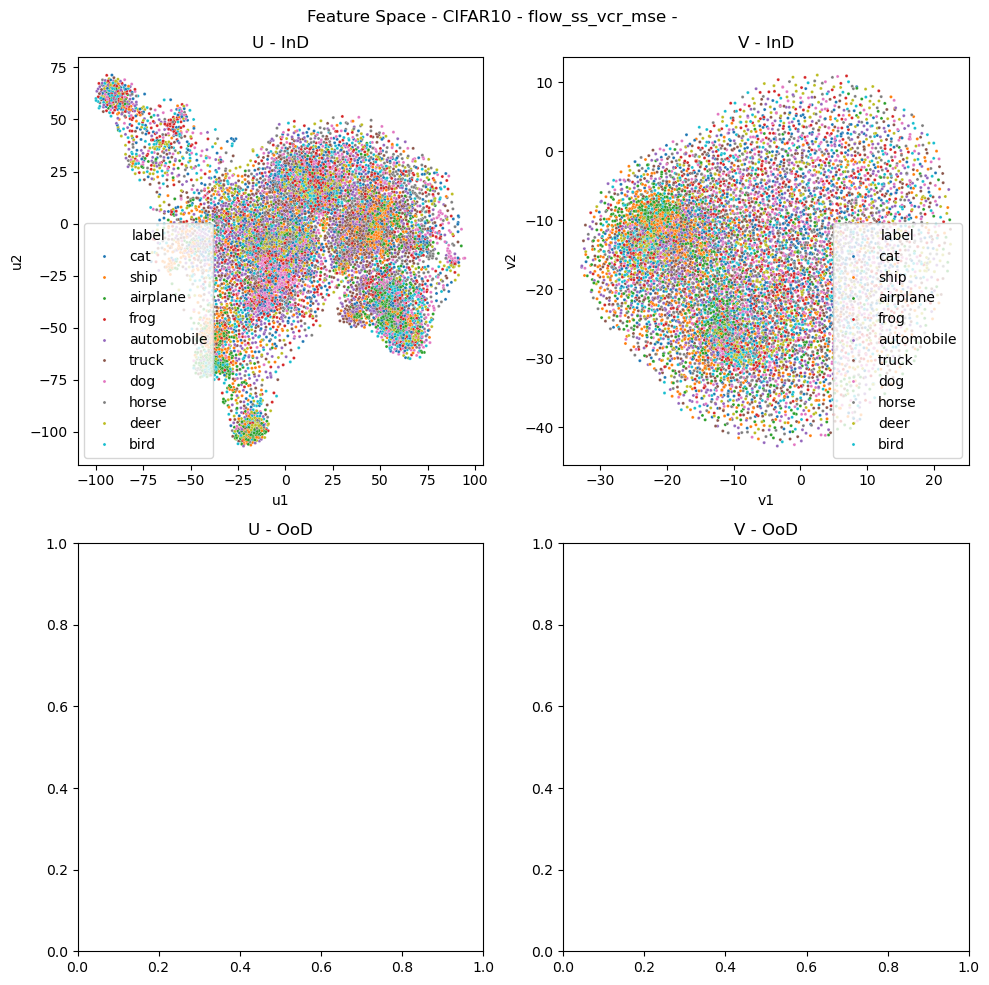

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:02,  1.28it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:01<00:01,  1.16it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:02<00:00,  1.19it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:03<00:09,  3.29s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:06<00:06,  3.30s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:09<00:03,  3.33s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.35s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.33s/it]

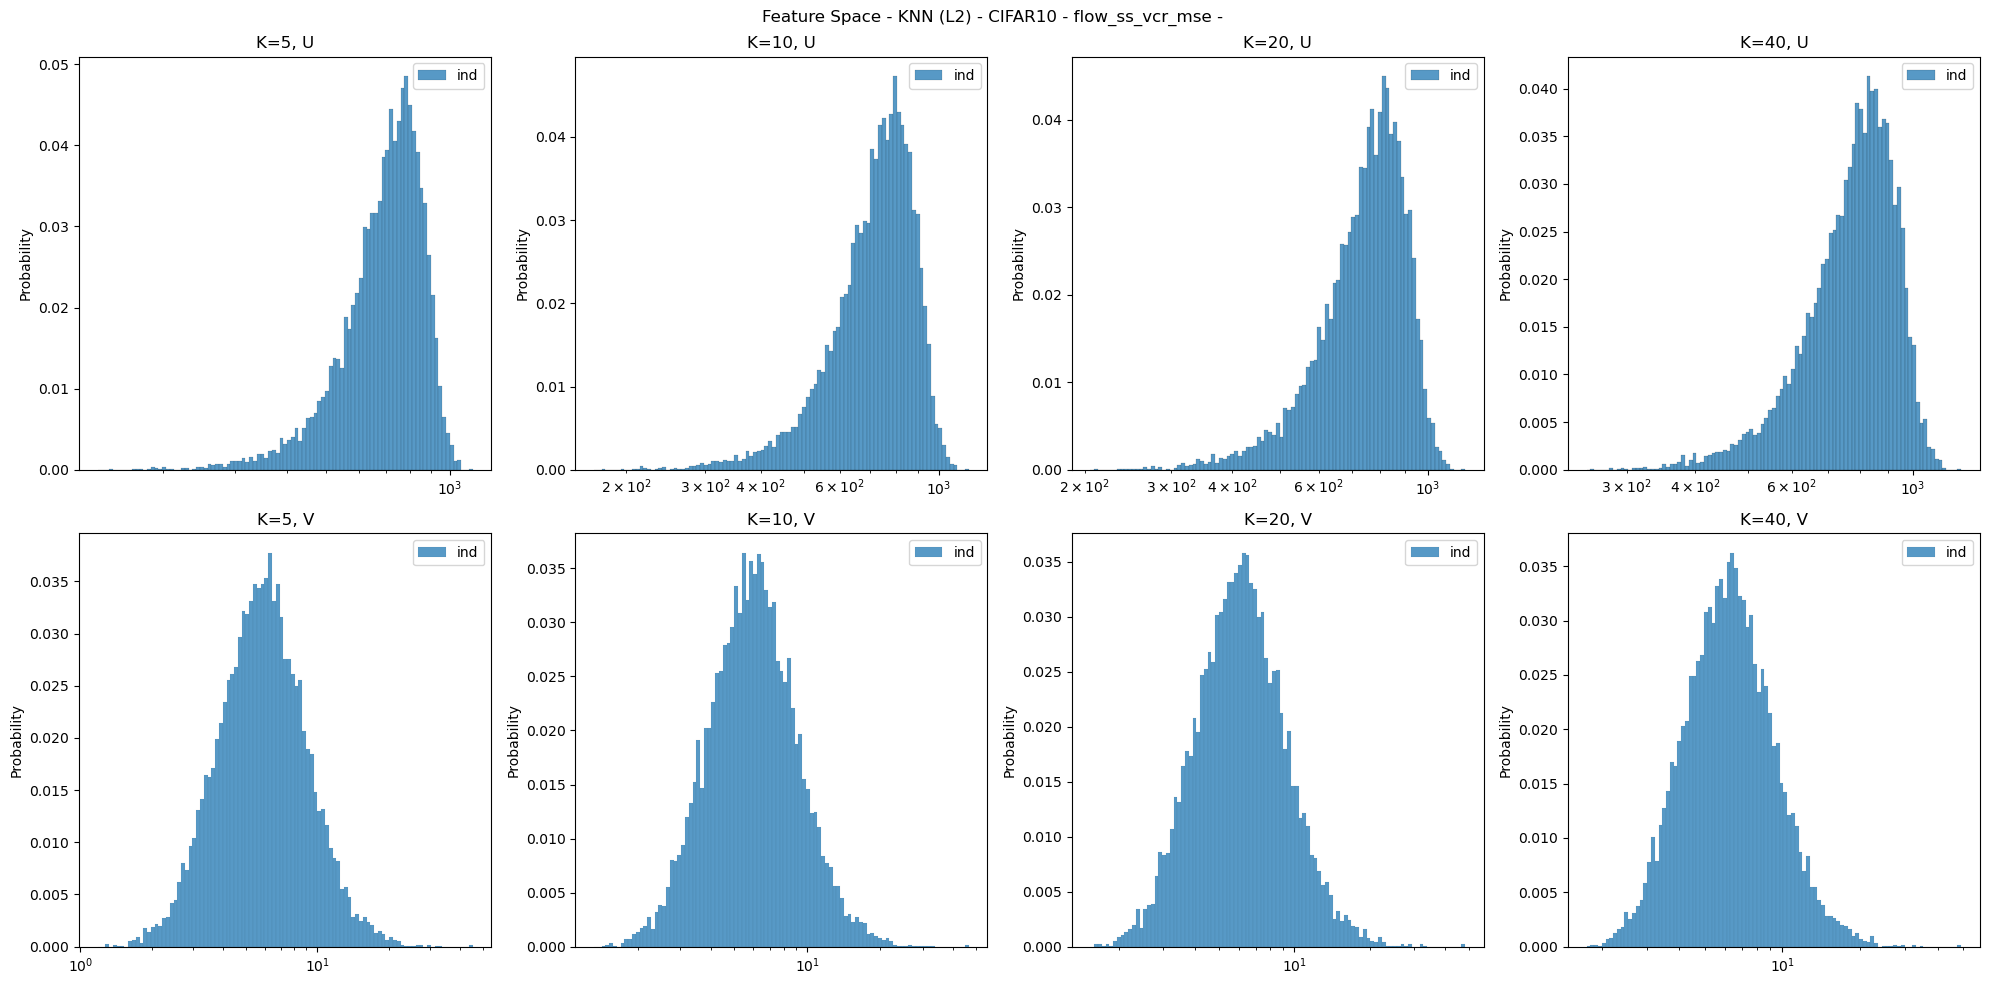

In [14]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatL2(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatL2(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:00<00:02,  1.31it/s]

 50%|████████████████████████████████████                                    | 2/4 [00:01<00:01,  1.31it/s]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:02<00:00,  1.29it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.16it/s]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.20it/s]

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:03<00:09,  3.26s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:06<00:06,  3.28s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:09<00:03,  3.30s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.32s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.31s/it]

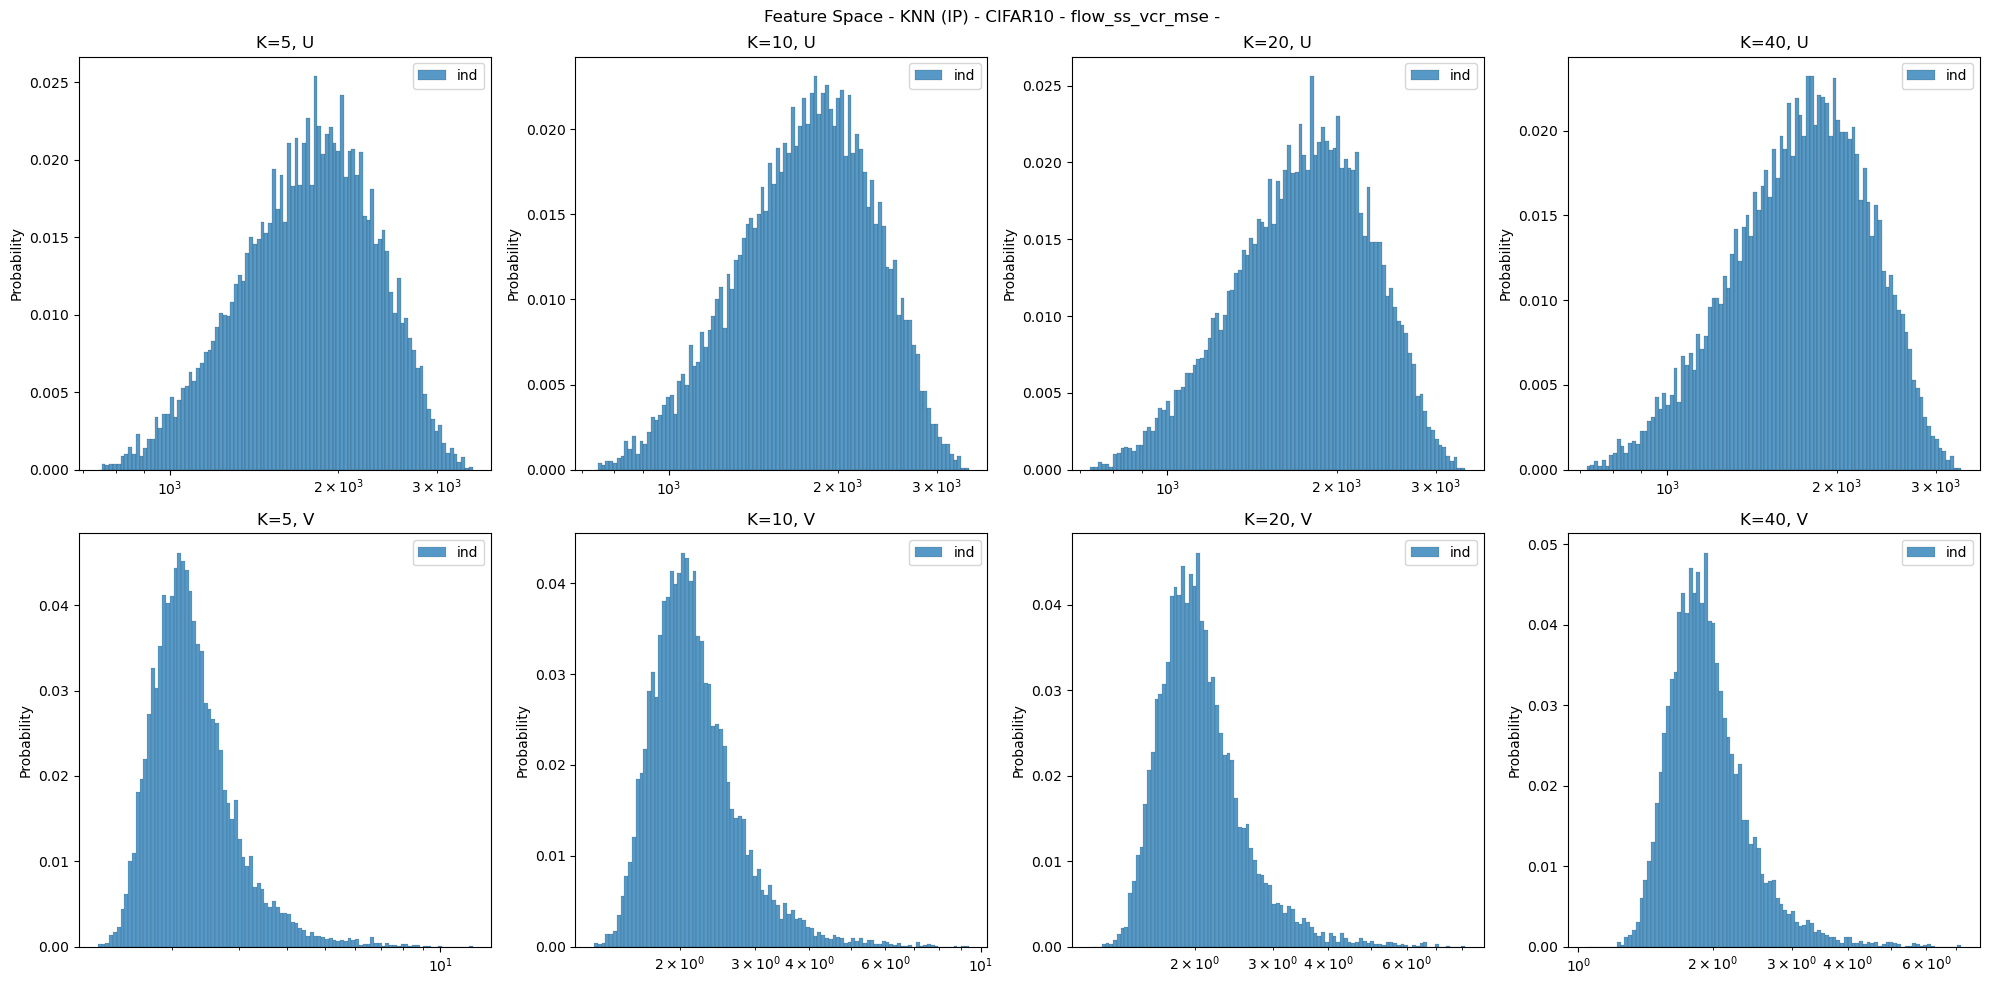

In [15]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatIP(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatIP(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

In [16]:
from scipy.linalg import norm

trn_n_u = norm(trn_e_u, axis=-1)
trn_n_v = norm(trn_e_v, axis=-1)
val_n_u = norm(val_e_u, axis=-1)
val_n_v = norm(val_e_v, axis=-1)
ind_n_u = norm(ind_e_u, axis=-1)
ind_n_v = norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = norm(ood_e_u, axis=-1)
    ood_n_v = norm(ood_e_v, axis=-1)
rnd_n_u = norm(rnd_e_u, axis=-1)
rnd_n_v = norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

42.486694 6.103777 2.5265832 0.5317802
42.430115 6.1788435 2.5165706 0.5325617
42.62547 6.135036 2.5249915 0.5312927
59.548553 2.7639012 45.830708 0.76391256


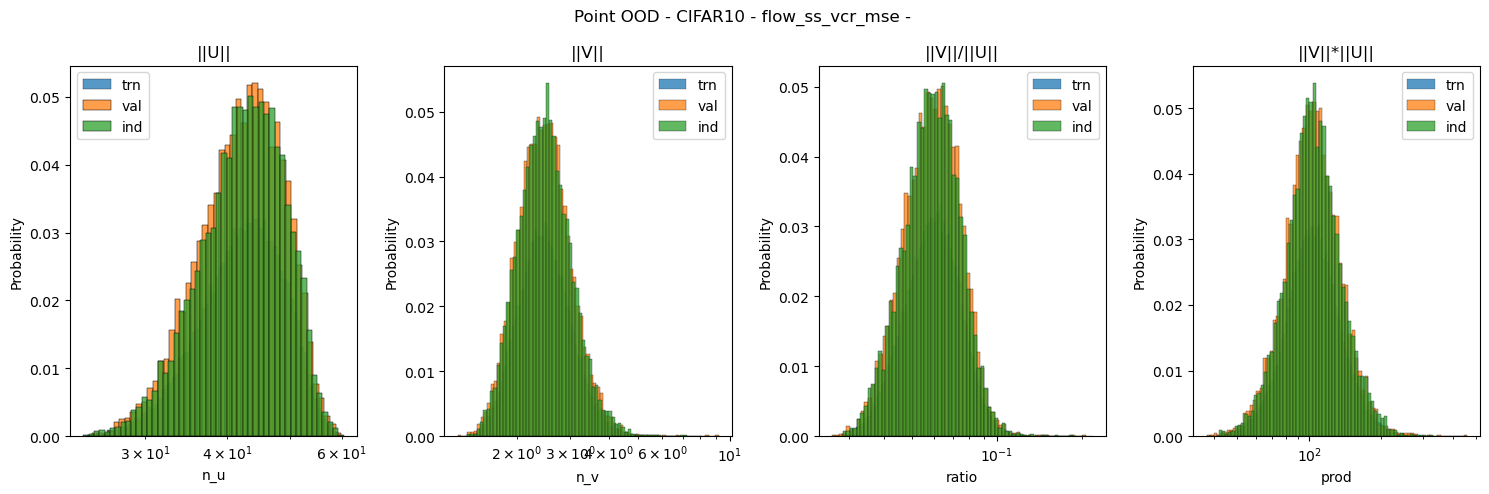

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [18]:
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


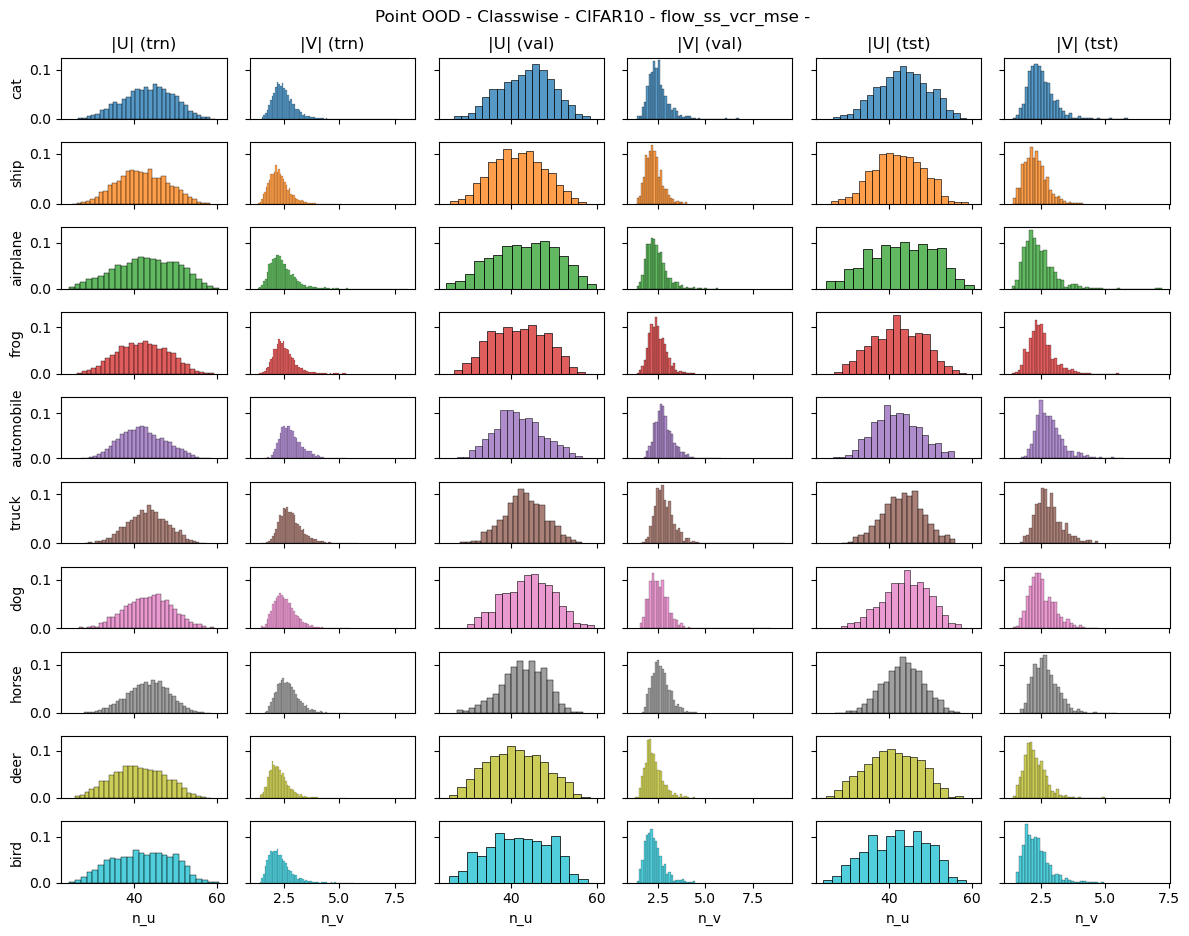

In [19]:
# pointwise
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

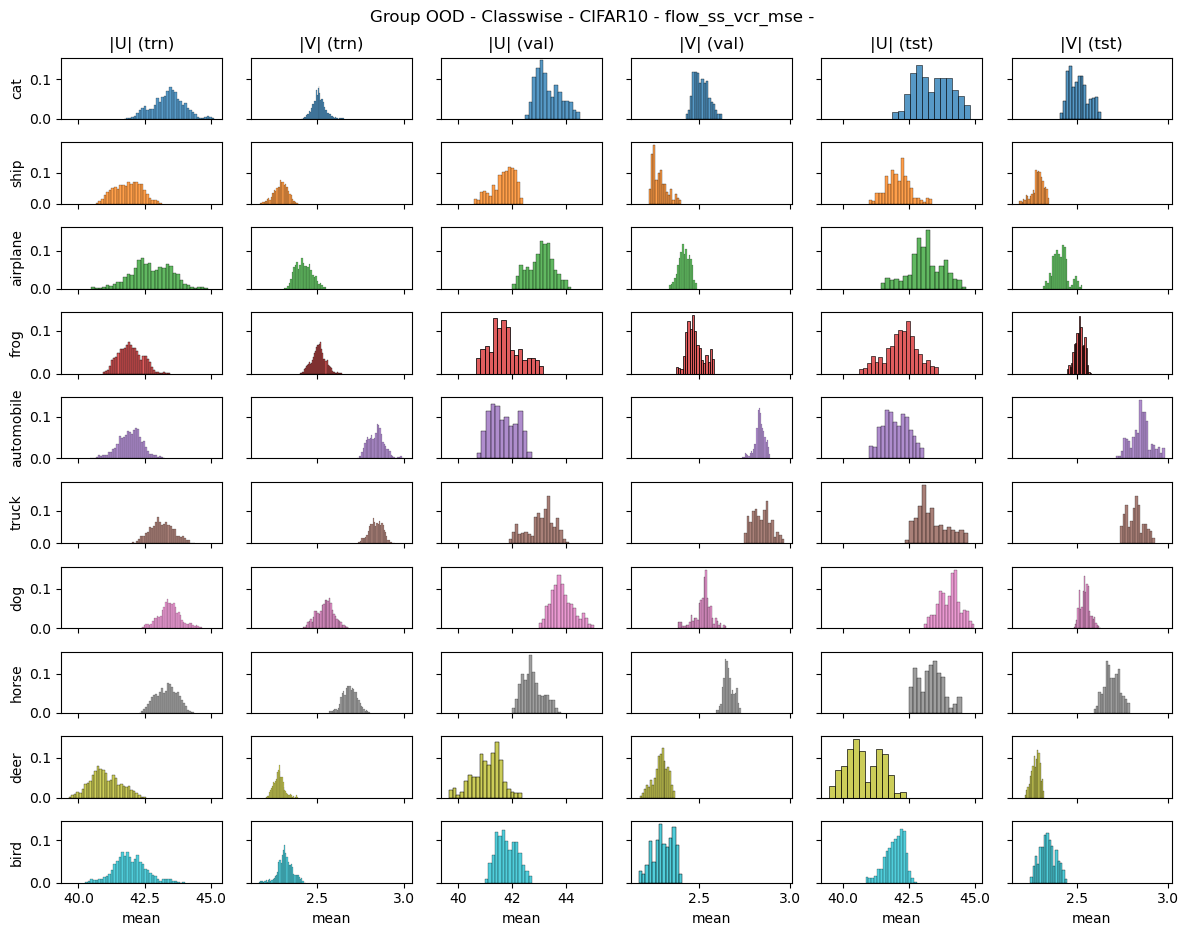

In [20]:
# groupwise
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

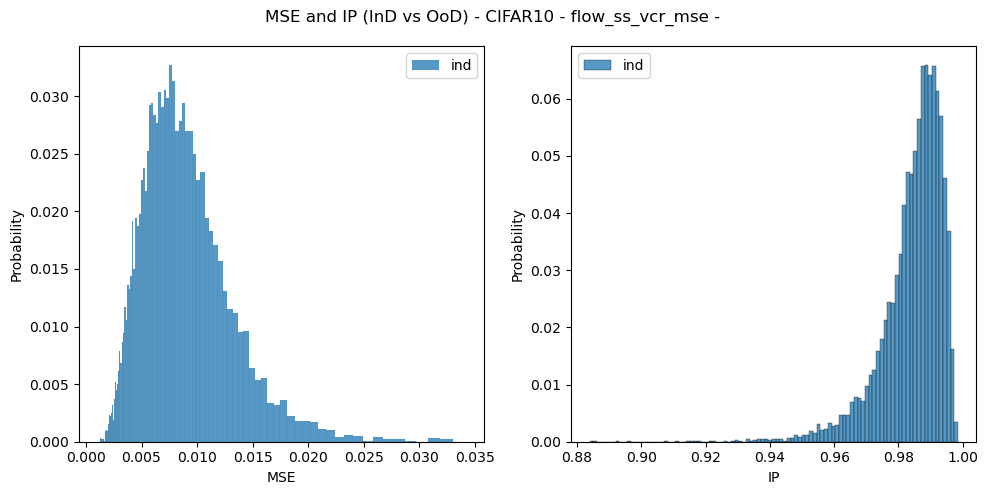

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_inp_norm = np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7
_ind_rcn_norm = np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7
ind_mse = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_ip = ((_ind_inp/_ind_inp_norm) * (_ind_rcn/_ind_rcn_norm)).sum(-1)
df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ind_tgt, mse=ind_mse, ip=ind_ip, source="ind"))], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_inp_norm = np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7
    _ood_rcn_norm = np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7
    ood_mse = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_ip = ((_ood_inp/_ood_inp_norm) * (_ood_rcn/_ood_rcn_norm)).sum(-1)
    df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ood_tgt, mse=ood_mse, ip=ood_ip, source="ood"))], ignore_index=True)
    
bins_mse = np.logspace(np.log10(df_rstat['mse'].min() + 1e-7), np.log10(df_rstat['mse'].max()), 100)
bins_ip = np.linspace(df_rstat['ip'].min(), df_rstat['ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="mse", label="ind", stat="probability", bins=bins_mse, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="ip", label="ind", stat="probability", bins=bins_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="mse", label="ood", stat="probability", bins=bins_mse, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="ip", label="ood", stat="probability", bins=bins_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("MSE")
ax2.set_xlabel("IP")
plt.suptitle(f"MSE and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()